# Практикум 4. Побудова моделi згорткових нейронних мереж для класифiкацiї зображень в TensorFlow

## Кабанова Марина КА-23

#### Набiр даних **20. Garbage Classification, kaggle.com**

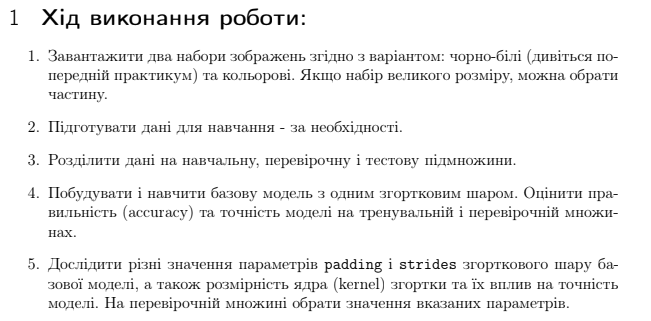
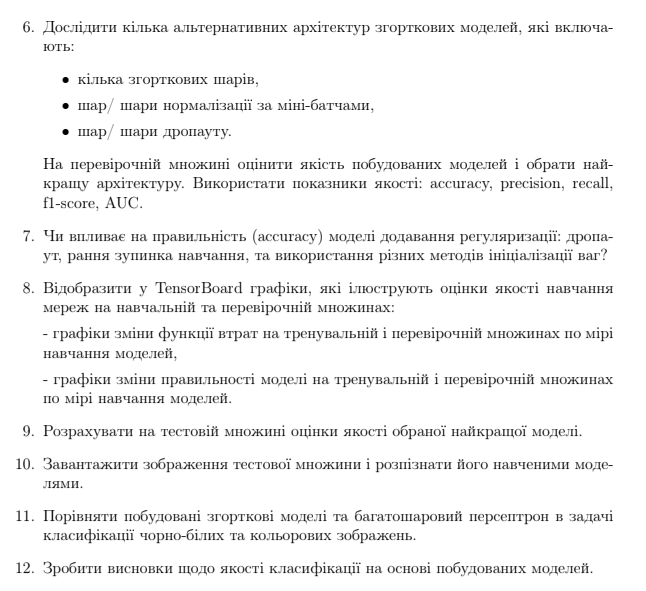

In [217]:
import splitfolders
import random
import os
import datetime
import cv2
import shutil
import imghdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle
from pathlib import Path

In [218]:
# Importing Keras 
import keras
from keras import layers
from keras.preprocessing import image
from keras.models import Sequential                          # Neural network model as a sequence of layers.
from keras.layers import Conv2D                              # Convolutional layer
from keras.layers import MaxPooling2D                        # Max pooling layer 
from keras.layers import Flatten                             # Layer used to flatten 2D arrays for fully-connected layers.
from keras.layers import Dense                               # This layer adds fully-connected layers to the neural network.
from keras.layers import Dropout                             # This serves to prevent overfitting by dropping out a random set of activations.
from keras.layers import BatchNormalization                  # This is used to normalize the activations of the neurons.
from keras.layers import Activation                          # Layer for activation functions
from keras.callbacks import EarlyStopping   # Classes used to save weights and stop training when improvements reach a limit

# Importing TensorFlow
import tensorflow as tf
from tensorflow.keras.utils import load_img 
from tensorflow.keras.callbacks import TensorBoard

In [219]:
data_dir = r"C:\Users\marak\Downloads\Garbage classification\Garbage classification"

classes = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]
splits = ['train', 'val', 'test']
split_ratios = {'train': 0.7, 'val': 0.15, 'test': 0.15} 

### Split data

In [4]:
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(data_dir, split, cls), exist_ok=True)

# Split data
for cls in classes:
    class_dir = os.path.join(data_dir, cls)
    images = os.listdir(class_dir)
    random.shuffle(images)

    total = len(images)
    train_end = int(split_ratios['train'] * total)
    val_end = train_end + int(split_ratios['val'] * total)

    split_files = {
        'train': images[:train_end],
        'val': images[train_end:val_end],
        'test': images[val_end:]
    }

    for split in splits:
        for fname in split_files[split]:
            src = os.path.join(class_dir, fname)
            dst = os.path.join(data_dir, split, cls, fname)
            shutil.copyfile(src, dst)

In [5]:
# Видаляємо окремі папки "cardboard", "glass", "metal", "paper", "plastic", "trash"
for cls in classes:
    dir_cls = os.path.join(data_dir, cls)
    shutil.rmtree(dir_cls)

In [149]:
train_dir = r"C:\Users\marak\Downloads\Garbage classification\Garbage classification\train"
test_dir = r"C:\Users\marak\Downloads\Garbage classification\Garbage classification\test"
val_dir = r"C:\Users\marak\Downloads\Garbage classification\Garbage classification\val"

In [7]:
# Giving names to each directory
directories = {
    train_dir: 'Train',
    test_dir: 'Test',
    val_dir: 'Validation'
    }

# Naming subfolders
classes = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

print('\n* * * * * Number of files in each folder * * * * *\n')
# Counting the total of pictures inside each subfolder and directory
for dir, name in directories.items():
    total = 0
    for cls in classes:
        path = os.path.join(dir, cls)
        num_files = len([f for f in os.listdir(path) if os.path.join(path, f)])
        total += num_files
        print(f'{name}/ {cls}: {num_files}')
    print(f'  Total: {total}')
    print("-" * 80)   


* * * * * Number of files in each folder * * * * *

Train/ cardboard: 282
Train/ glass: 350
Train/ metal: 287
Train/ paper: 415
Train/ plastic: 337
Train/ trash: 95
  Total: 1766
--------------------------------------------------------------------------------
Test/ cardboard: 61
Test/ glass: 76
Test/ metal: 62
Test/ paper: 90
Test/ plastic: 73
Test/ trash: 22
  Total: 384
--------------------------------------------------------------------------------
Validation/ cardboard: 60
Validation/ glass: 75
Validation/ metal: 61
Validation/ paper: 89
Validation/ plastic: 72
Validation/ trash: 20
  Total: 377
--------------------------------------------------------------------------------


#### Check the dataset distribution.

In [8]:
unique_dimensions = set()

for dir, name in directories.items():
    for sub in classes:
        folder_path = os.path.join(dir, sub)
        
        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                unique_dimensions.add(img.size)
                
if len(unique_dimensions) == 1:
    print(f"\nAll images have the same dimensions: {unique_dimensions.pop()}")
else:
    print(f"\nFound {len(unique_dimensions)} unique image dimensions: {unique_dimensions}")


All images have the same dimensions: (512, 384)


#### Check if all images have pixel values between 0 and 255.

In [9]:
# Checking images dtype
all_uint8 = True
all_in_range = True

for dir, name in directories.items():
    for cls in classes:
        folder_path = os.path.join(dir, cls)
        
        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                img_array = np.array(img)
                
            if img_array.dtype != 'uint8':
                all_uint8 = False
            
            if img_array.min() < 0 or img_array.max() > 255:
                all_in_range = False
                
if all_uint8:
    print(" - All images are of data type uint8")
else:
    print(" - Not all images are of data type uint8")
    
if all_in_range:
    print(" - All images have pixel values ranging from 0 to 255")
else:
    print(" - Not all images have the same pixel values from 0 to 255")

 - All images are of data type uint8
 - All images have pixel values ranging from 0 to 255


# Plot Data

In [10]:
def plot_images(path, title, num_images=5):
    image_filenames = random.sample(os.listdir(path), num_images)
    
    fig, axes = plt.subplots(1, 5, figsize = (12,4), facecolor='aliceblue')
    axes = axes.flatten()
    
    for i, image_filename in enumerate(image_filenames[:num_images]):
        image_path = os.path.join(path, image_filename)
        images =  Image.open(image_path)
        
        # Display the image
        axes[i].imshow(images)
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(os.path.splitext(os.path.basename(image_filename))[0])
    
    fig.suptitle(f'Picture of {title}',fontsize=16)
    plt.tight_layout()
    plt.show()

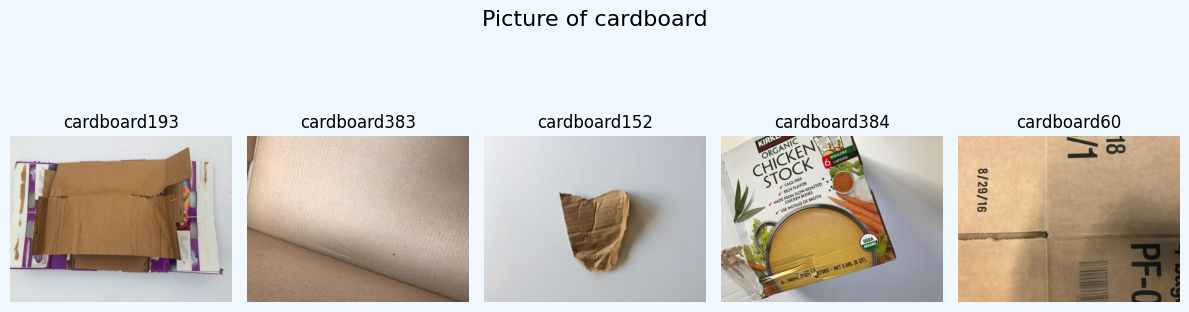

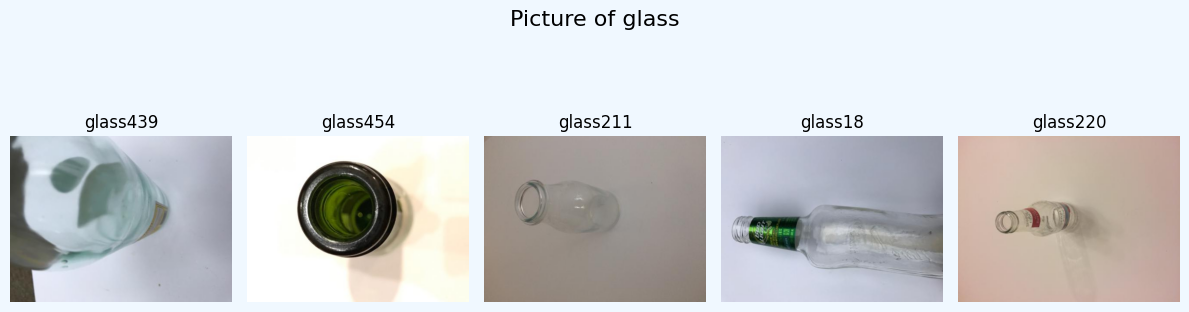

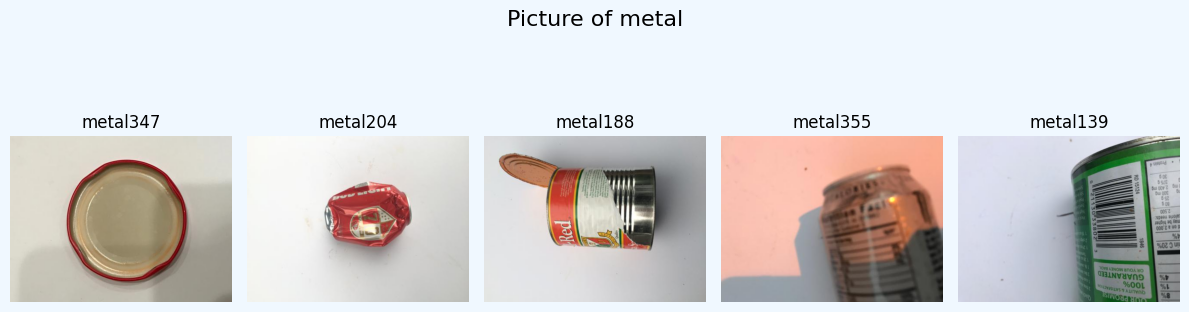

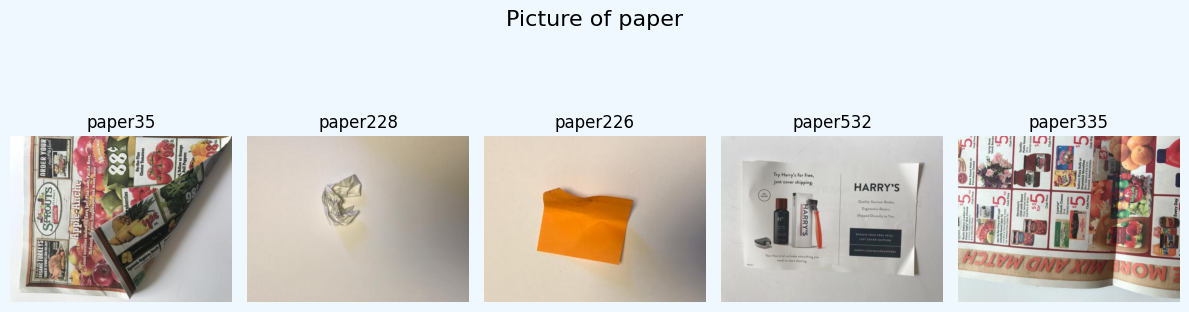

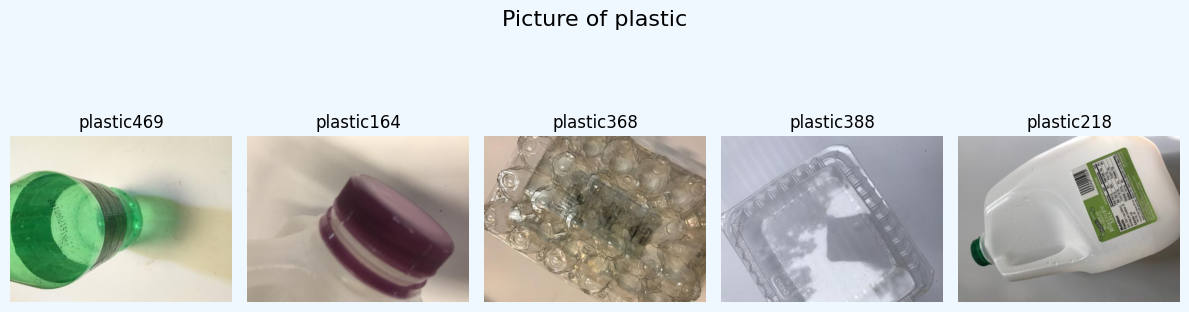

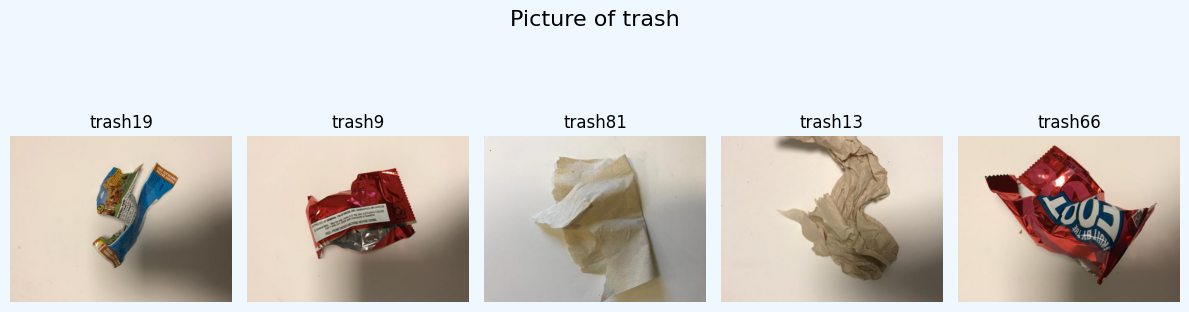

In [11]:
for i, cls in enumerate(classes):
    plot_images(train_dir + '/' + classes[i], cls)

# Data Preprocessing 

In [12]:
color_mode='rgb'
batch_size=32
image_size=(256, 256)

###  Load a dataset

In [13]:
def load_dataset(dir):
    ds = tf.keras.utils.image_dataset_from_directory(dir,
                                                       labels = "inferred",
                                                       label_mode = 'categorical',
                                                       class_names = classes,
                                                       color_mode='rgb',
                                                       batch_size=32,
                                                       image_size = image_size,
                                                       shuffle = True,
                                                       crop_to_aspect_ratio = True #змінить розмір зображення без спотворення співвідношення сторін.
                                                      ) 
    return ds

In [14]:
train_ds = load_dataset(train_dir)
test_ds = load_dataset(test_dir) 
val_ds = load_dataset(val_dir)     

Found 1766 files belonging to 6 classes.
Found 384 files belonging to 6 classes.
Found 377 files belonging to 6 classes.


In [15]:
print('\nTraining Dataset:', train_ds)
print('\nTesting Dataset:',  test_ds)
print('\nValidation Dataset:', val_ds)


Training Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>

Testing Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>

Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>


* height, width of images = 256, 256
* 3 is the number of channels in the images, indicating they are RGB images
* batch size = none
* 6 labels 

#### Convert a pixel values of images within a 0 and 1

In [16]:
train_ds = train_ds.map(lambda x,y: (x/255, y))
test_ds = test_ds.map(lambda x,y: (x/255, y))
val_ds = val_ds.map(lambda x,y: (x/255, y))

## Data augmentation
a technique to increase the diversity of your training set by applying random (but realistic) transformations.

In [25]:
data_augmentation = tf.keras.Sequential([
  layers.Input(shape=(256,256, 3)),
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomContrast(0.2),
  layers.RandomRotation(0.25)])

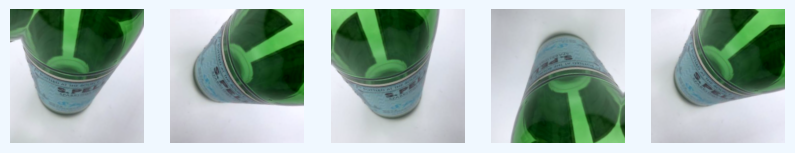

In [26]:
plt.figure(figsize=(10,10), facecolor='aliceblue')
for images, _ in train_ds.take(1):
    for i in range(5):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(1, 5, i+1)
        plt.imshow(np.clip(augmented_images[0].numpy(), 0, 1))
        plt.axis('off')

In [27]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                        num_parallel_calls=tf.data.AUTOTUNE)


## Early Stopping

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True)

# Model Creation

In [28]:
def performance_plot(model, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(9, 8), facecolor='aliceblue')
    
    plt.subplot(2,1,1)
    plt.plot(acc,  label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='upper right')
    
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss,  label='Validation Loss')
    plt.legend(loc='upper right')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title('Training and Validation Loss')
    plt.tight_layout()
    plt.show()

In [133]:
def metrics(model, val_ds):
    # Evaluate the model on the validation dataset
    val_loss, val_accuracy, val_precision, val_recall, auc = model.evaluate(val_ds, verbose=0)
    print(f'\nValidation Loss: {val_loss:.2f}')
    print(f'Validation Accuracy: {100 * val_accuracy:.2f}%')
    print(f'Validation Precision: {100 * val_precision:.2f}%')
    print(f'Validation Recall: {100 * val_recall:.2f}%')
    print(f'AUC: {100 * auc:.2f}%')
    
    return np.array([val_loss, val_accuracy, val_precision, val_recall, auc])

# 1. Base Model
#### один згортковий шар

**Аргумент padding** визначає як бути з вiкнами, якi виходять за межi вхiдного
масиву i може приймати два значення:
* padding = "VALID" призведе до того, що будуть застосовуватися згортки тiльки на тих вiкнах, якi повнiстю помiщаються в межах вхiдного масиву; тому розмiр масиву на виходi стане менше, нiж був на входi; Наприклад, у зображення розмiром 28 × 28 помiстяться тiльки 24 × 24 вiкон розмiру 5 × 5, а два пiкселя «рамки» не зможуть стати центрами згорткових ваг. Наступний шар буде мати розмiр 24 × 24, а не 28 × 28.
* padding = "SAME" призведе до того, що розмiр шару збережеться, а при виходi за межi масиву виконується доповнення вхiдного масиву нулями. В цьому випадку пiкселi з «рамки» теж стануть центрами згорткових ваг, тiльки деякi значення у них будуть нульовими.

**Аргумент strides** задає крок по зображенню, визначає як часто застосовуються
фiльтри по кожнiй з чотирьох розмiрностей вхiдного тензора. 
* Якщо для вхiдного тензора задати strides = [1,3,3,1], то вiкна будуть не всi можливi, а лише з iнтервалом в три пiкселя.
* Перша компонента strides вiдповiдає рiзним прикладам в мiнi-батчi. У випадку з
обробкою зображень значення першої компоненти strides зазвичай береться рiвним 1.
Якщо це значення не дорiвнює одиницi, то частина вхiдних прикладiв пропускається.
Аргумент strides в TensorFlow є бiльш загальним i може бути застосований до
будь-якого тензора, звiдси i «зайвi» розмiрностi.

In [30]:
input_shape = (256, 256, 3)

In [34]:
def cnn(kernel_size, strides, padding):
    #Створення базової згорткової моделi з одним згортковим шаром i шаром макспулiнгу:
    model = Sequential([
        layers.Input(shape=(256, 256, 3)), 
        layers.Conv2D(32, kernel_size=kernel_size, strides=strides, padding=padding, activation="relu"),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.Flatten(), # layer converts all feature maps into a one-dimensional vector
        layers.Dense(64, activation='relu'),
        layers.Dense(len(classes), activation='softmax') # Output Classification layer
        ])
    
    model.compile(loss='categorical_crossentropy', optimizer = 'adam', 
                  metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
    model.summary()
    print('\n')
    return model

In [49]:
performance = []

for kernel_size in [(2, 2),(3, 3)]:
    for strides in [(1,1),(2, 2),(3, 3)]:
        print(f'\n***** Padding: {'same'} | Strides: {strides} | Kernel: {kernel_size} *****')
        model = cnn(kernel_size=kernel_size, strides=strides, padding = 'same')
        history = model.fit(train_ds, epochs = 7, validation_data = val_ds, verbose = 0, callbacks = [early_stopping])
        val_loss, val_accuracy, val_precision, val_recall, val_auc = model.evaluate(val_ds, verbose=0)
        print(f'\nValidation Loss: {val_loss:.2f}')
        print(f'Validation Accuracy: {100 * val_accuracy:.2f}%')
        print(f'Validation Precision: {100 * val_precision:.2f}%')
        print(f'Validation Recall: {100 * val_recall:.2f}%')
        performance.append([kernel_size, 'same', strides, val_loss, val_accuracy, val_precision, val_recall, val_auc])

df_performance = pd.DataFrame(performance, columns = ['Kernel','Padding', 'Strides','Val Loss','Val Acc', 'Val Precision', 'Val Recall', 'Val AUC'])


***** Padding: same | Strides: (1, 1) | Kernel: (2, 2) *****


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)            │ (None, 256, 256, 32)  │          416 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_12              │ (None, 128, 128, 32)  │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_6 (Flatten)           │ (None, 524288)        │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_12 (Dense)              │ (None, 64)            │   33,554,496 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_13 (Dense)              │ (None, 6)             │          390 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 33,555,302 (128.00 MB)

 Trainable params: 33,555,302 (128.00 MB)

 Non-trainable params: 0 (0.00 B)




Validation Loss: 1.30
Validation Accuracy: 47.48%
Validation Precision: 72.99%
Validation Recall: 33.69%

***** Padding: same | Strides: (2, 2) | Kernel: (2, 2) *****


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)            │ (None, 128, 128, 32)  │          416 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_13              │ (None, 64, 64, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_7 (Flatten)           │ (None, 131072)        │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_14 (Dense)              │ (None, 64)            │    8,388,672 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_15 (Dense)              │ (None, 6)             │          390 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 8,389,478 (32.00 MB)

 Trainable params: 8,389,478 (32.00 MB)

 Non-trainable params: 0 (0.00 B)




Validation Loss: 1.10
Validation Accuracy: 57.82%
Validation Precision: 79.31%
Validation Recall: 36.60%

***** Padding: same | Strides: (3, 3) | Kernel: (2, 2) *****


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)            │ (None, 86, 86, 32)    │          416 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_14              │ (None, 43, 43, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_8 (Flatten)           │ (None, 59168)         │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_16 (Dense)              │ (None, 64)            │    3,786,816 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_17 (Dense)              │ (None, 6)             │          390 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 3,787,622 (14.45 MB)

 Trainable params: 3,787,622 (14.45 MB)

 Non-trainable params: 0 (0.00 B)




Validation Loss: 1.20
Validation Accuracy: 59.15%
Validation Precision: 74.48%
Validation Recall: 28.65%

***** Padding: same | Strides: (1, 1) | Kernel: (3, 3) *****


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)            │ (None, 256, 256, 32)  │          896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_15              │ (None, 128, 128, 32)  │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_9 (Flatten)           │ (None, 524288)        │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_18 (Dense)              │ (None, 64)            │   33,554,496 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_19 (Dense)              │ (None, 6)             │          390 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 33,555,782 (128.01 MB)

 Trainable params: 33,555,782 (128.01 MB)

 Non-trainable params: 0 (0.00 B)




Validation Loss: 1.30
Validation Accuracy: 49.60%
Validation Precision: 73.39%
Validation Recall: 24.14%

***** Padding: same | Strides: (2, 2) | Kernel: (3, 3) *****


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)            │ (None, 128, 128, 32)  │          896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_16              │ (None, 64, 64, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_10 (Flatten)          │ (None, 131072)        │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_20 (Dense)              │ (None, 64)            │    8,388,672 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_21 (Dense)              │ (None, 6)             │          390 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 8,389,958 (32.01 MB)

 Trainable params: 8,389,958 (32.01 MB)

 Non-trainable params: 0 (0.00 B)




Validation Loss: 1.21
Validation Accuracy: 53.05%
Validation Precision: 74.19%
Validation Recall: 30.50%

***** Padding: same | Strides: (3, 3) | Kernel: (3, 3) *****


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)            │ (None, 86, 86, 32)    │          896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_17              │ (None, 43, 43, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_11 (Flatten)          │ (None, 59168)         │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_22 (Dense)              │ (None, 64)            │    3,786,816 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_23 (Dense)              │ (None, 6)             │          390 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 3,788,102 (14.45 MB)

 Trainable params: 3,788,102 (14.45 MB)

 Non-trainable params: 0 (0.00 B)




Validation Loss: 1.23
Validation Accuracy: 52.25%
Validation Precision: 81.75%
Validation Recall: 29.71%


In [54]:
df_performance

Kernel Padding Strides  Val Loss   Val Acc  Val Precision  Val Recall  \
0  (2, 2)    same  (1, 1)  1.303010  0.474801       0.729885    0.336870   
1  (2, 2)    same  (2, 2)  1.100297  0.578249       0.793103    0.366048   
2  (2, 2)    same  (3, 3)  1.195702  0.591512       0.744828    0.286472   
3  (3, 3)    same  (1, 1)  1.297665  0.496021       0.733871    0.241379   
4  (3, 3)    same  (2, 2)  1.209131  0.530504       0.741935    0.305040   
5  (3, 3)    same  (3, 3)  1.227394  0.522546       0.817518    0.297082   

    Val AUC  
0  0.819755  
1  0.879093  
2  0.859121  
3  0.826013  
4  0.851507  
5  0.844780

* Найвища точність: **kernel_size=(2, 2), strides=(3, 3), padding = 'same'**. Однак досить високе значення функції втрат.
* Також висока точність, кращі значення інших метрик: **kernel_size=(2, 2), strides=(2, 2), padding = 'same'**

Модель за цих параметрів мала найкращу поведінку, тому дослідимо їх окремо на більшій кількості епох. 

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)            │ (None, 256, 256, 32)  │          896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_22              │ (None, 128, 128, 32)  │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_14 (Flatten)          │ (None, 524288)        │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_28 (Dense)              │ (None, 64)            │   33,554,496 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_29 (Dense)              │ (None, 6)             │          390 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 33,555,782 (128.01 MB)

 Trainable params: 33,555,782 (128.01 MB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 699ms/step - accuracy: 0.1845 - auc_13: 0.5239 - loss: 22.5424 - precision_14: 0.1889 - recall_14: 0.1584 - val_accuracy: 0.3687 - val_auc_13: 0.7331 - val_loss: 1.5569 - val_precision_14: 0.5000 - val_recall_14: 0.0928
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 696ms/step - accuracy: 0.3959 - auc_13: 0.7573 - loss: 1.5187 - precision_14: 0.6503 - recall_14: 0.1652 - val_accuracy: 0.4960 - val_auc_13: 0.7893 - val_loss: 1.3883 - val_precision_14: 0.7168 - val_recall_14: 0.2149
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 691ms/step - accuracy: 0.4672 - auc_13: 0.8071 - loss: 1.3661 - precision_14: 0.7204 - recall_14: 0.2437 - val_accuracy: 0.5146 - val_auc_13: 0.8368 - val_loss: 1.2537 - val_precision_14: 0.7578 - val_recall_14: 0.2573
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 690ms/step - accuracy: 0.5300 - auc_13: 0.8323 - loss: 1.2859 - precision_14: 0.7284 - recall_14: 0.3025 - val_accuracy: 0.4907 - val_auc_13: 0.8231 - val_loss: 1.2860 - va

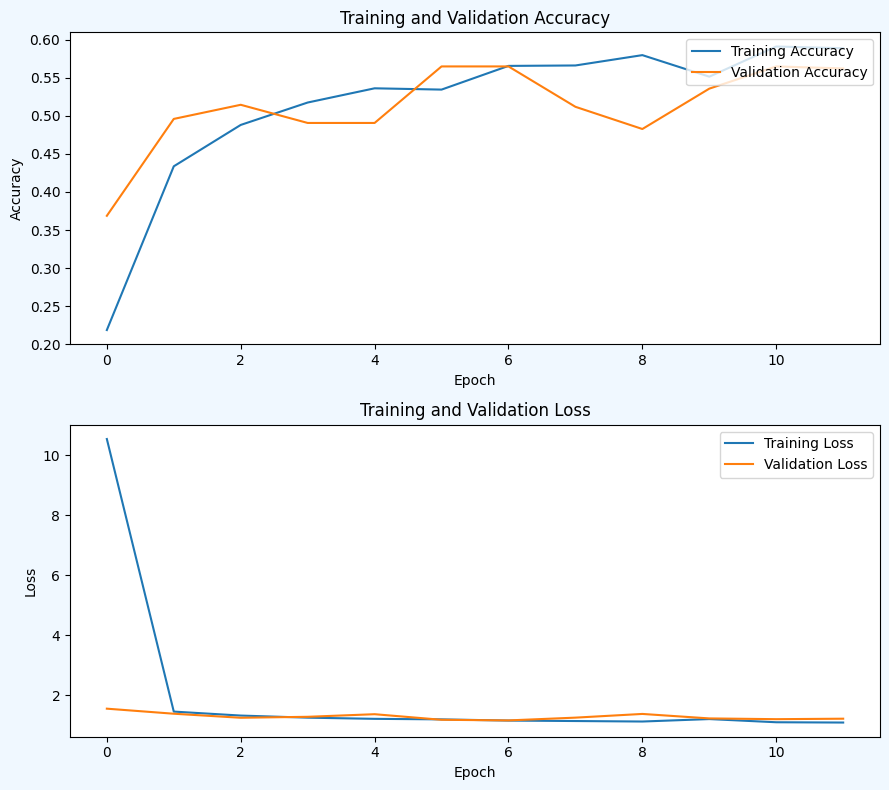

In [55]:
model1 = cnn(kernel_size=(3, 3), strides=(1, 1), padding = 'same')
history = model1.fit(train_ds, epochs = 20, validation_data = val_ds, callbacks = [early_stopping])
print(f' **** Base model performance kernel_size=(3, 3), strides=(1, 1), padding = same:')
metrics_model1 = metrics(model1, val_ds)
performance_plot(model1, history)

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)            │ (None, 128, 128, 32)  │          416 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_23              │ (None, 64, 64, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_15 (Flatten)          │ (None, 131072)        │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_30 (Dense)              │ (None, 64)            │    8,388,672 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_31 (Dense)              │ (None, 6)             │          390 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 8,389,478 (32.00 MB)

 Trainable params: 8,389,478 (32.00 MB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - accuracy: 0.2162 - auc_14: 0.5683 - loss: 5.5740 - precision_15: 0.2501 - recall_15: 0.1374 - val_accuracy: 0.3952 - val_auc_14: 0.7811 - val_loss: 1.4478 - val_precision_15: 0.5888 - val_recall_15: 0.1671
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 215ms/step - accuracy: 0.4420 - auc_14: 0.7718 - loss: 1.4907 - precision_15: 0.6056 - recall_15: 0.2222 - val_accuracy: 0.4801 - val_auc_14: 0.7872 - val_loss: 1.4027 - val_precision_15: 0.6892 - val_recall_15: 0.2706
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 215ms/step - accuracy: 0.4788 - auc_14: 0.8144 - loss: 1.3319 - precision_15: 0.7291 - recall_15: 0.2504 - val_accuracy: 0.5305 - val_auc_14: 0.8258 - val_loss: 1.2875 - val_precision_15: 0.7292 - val_recall_15: 0.2785
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 219ms/step - accuracy: 0.5100 - auc_14: 0.8361 - loss: 1.2510 - precision_15: 0.7544 - recall_15: 0.2892 - val_accuracy: 0.5570 - val_auc_14: 0.8432 - val_loss: 1.2290 - val

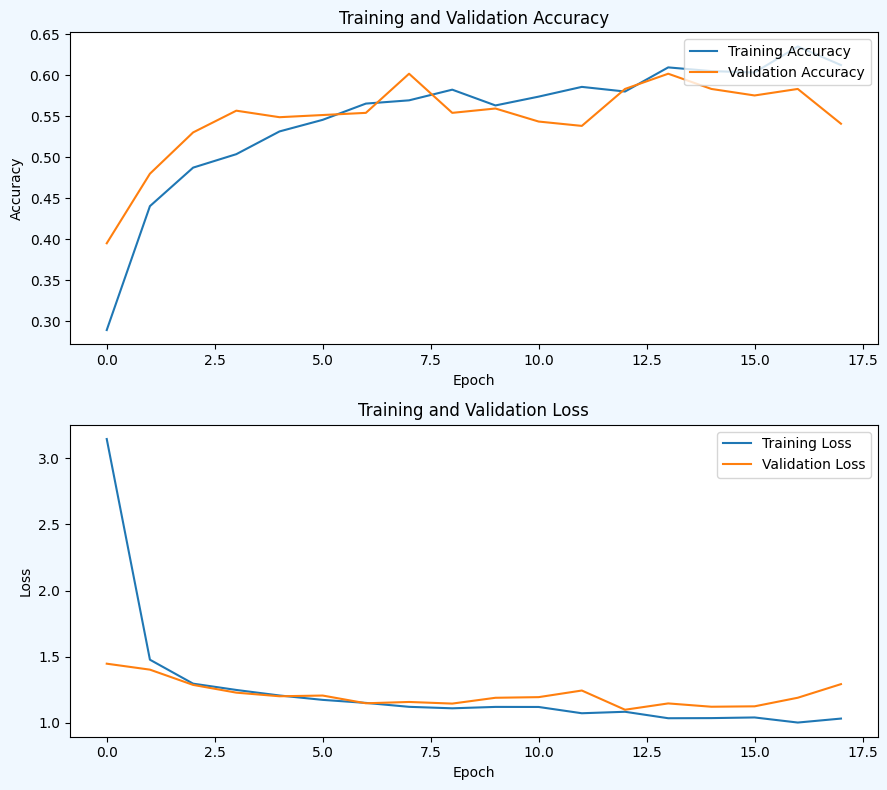

In [56]:
model2 = cnn(kernel_size=(2, 2), strides=(2, 2), padding = 'same')
history = model2.fit(train_ds, epochs = 20, validation_data = val_ds, callbacks = [early_stopping])
print(f' **** Base model performance kernel_size=(2, 2), strides=(2, 2), padding = same:')
metrics_model2 = metrics(model2, val_ds)
performance_plot(model2, history)

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)            │ (None, 86, 86, 32)    │          416 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_24              │ (None, 43, 43, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_16 (Flatten)          │ (None, 59168)         │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_32 (Dense)              │ (None, 64)            │    3,786,816 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_33 (Dense)              │ (None, 6)             │          390 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 3,787,622 (14.45 MB)

 Trainable params: 3,787,622 (14.45 MB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.2400 - auc_15: 0.5819 - loss: 3.9255 - precision_16: 0.2364 - recall_16: 0.0884 - val_accuracy: 0.3820 - val_auc_15: 0.7294 - val_loss: 1.5617 - val_precision_16: 1.0000 - val_recall_16: 0.0371
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.3463 - auc_15: 0.7059 - loss: 1.5993 - precision_16: 0.8608 - recall_16: 0.0647 - val_accuracy: 0.4111 - val_auc_15: 0.7685 - val_loss: 1.4480 - val_precision_16: 0.8444 - val_recall_16: 0.1008
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.3533 - auc_15: 0.7482 - loss: 1.4920 - precision_16: 0.7738 - recall_16: 0.0917 - val_accuracy: 0.4058 - val_auc_15: 0.7770 - val_loss: 1.4391 - val_precision_16: 0.7925 - val_recall_16: 0.1114
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.3548 - auc_15: 0.7558 - loss: 1.4809 - precision_16: 0.7582 - recall_16: 0.1025 - val_accuracy: 0.3846 - val_auc_15: 0.7736 - val_loss: 1.4505 - val_pr

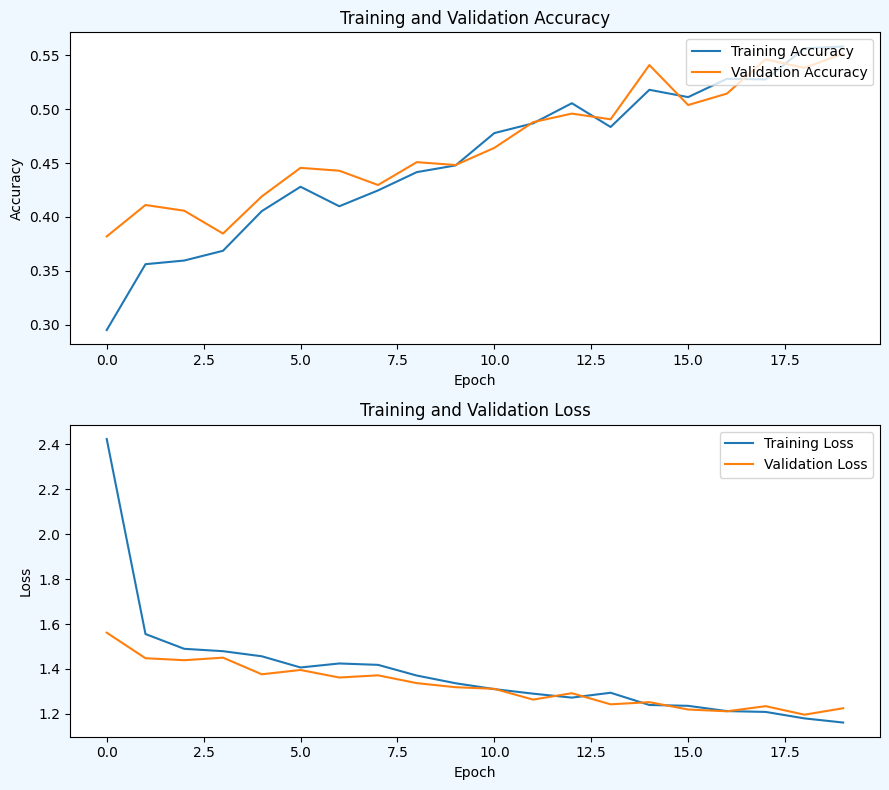

In [57]:
model3 = cnn(kernel_size=(2, 2), strides=(3, 3), padding = 'same')
history = model3.fit(train_ds, epochs = 20, validation_data = val_ds, callbacks = [early_stopping])
print(f' **** Base model performance kernel_size=(2, 2), strides=(3, 3), padding = same:')
metrics_model2 = metrics(model3, val_ds)
performance_plot(model3, history)

В рузультаті накращим результатом є модель з паметрами kernel_size=(2, 2), strides=(2, 2), padding = 'same'

* Validation Loss: 1.10
* Validation Accuracy: 58.36%
* Validation Precision: 73.09%
* Validation Recall: 43.24%
* AUC: 0.88%

#### Base Model: base_model = cnn(kernel_size=(2, 2), strides=(2, 2), padding = 'same')

## 2. Several Layers
Побудуємо моделі з кількомі згортковими шарами, перевіримо вплив шарів нормалізації за міні-батчами та дропаутом.

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_67 (Conv2D)            │ (None, 128, 128, 32)  │          416 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_67              │ (None, 64, 64, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_68 (Conv2D)            │ (None, 32, 32, 64)    │        8,256 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_68              │ (None, 16, 16, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_69 (Conv2D)            │ (None, 8, 8, 128)     │       32,896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_69              │ (None, 4, 4, 128)     │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_31 (Flatten)          │ (None, 2048)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_62 (Dense)              │ (None, 128)           │      262,272 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_63 (Dense)              │ (None, 6)             │          774 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 304,614 (1.16 MB)

 Trainable params: 304,614 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.2339 - auc_30: 0.6142 - loss: 1.7209 - precision_31: 0.0105 - recall_31: 5.0334e-05 - val_accuracy: 0.3528 - val_auc_30: 0.7312 - val_loss: 1.5341 - val_precision_31: 0.7500 - val_recall_31: 0.0159
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.3679 - auc_30: 0.7277 - loss: 1.5572 - precision_31: 0.7350 - recall_31: 0.0390 - val_accuracy: 0.3793 - val_auc_30: 0.7663 - val_loss: 1.4640 - val_precision_31: 0.6833 - val_recall_31: 0.1088
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.4344 - auc_30: 0.7795 - loss: 1.4330 - precision_31: 0.7628 - recall_31: 0.1225 - val_accuracy: 0.4218 - val_auc_30: 0.7891 - val_loss: 1.3967 - val_precision_31: 0.6907 - val_recall_31: 0.1777
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.4830 - auc_30: 0.8108 - loss: 1.3437 - precision_31: 0.7129 - recall_31: 0.1901 - val_accuracy: 0.4721 - val_auc_30: 0.8373 - val_loss: 1.2453 - val_

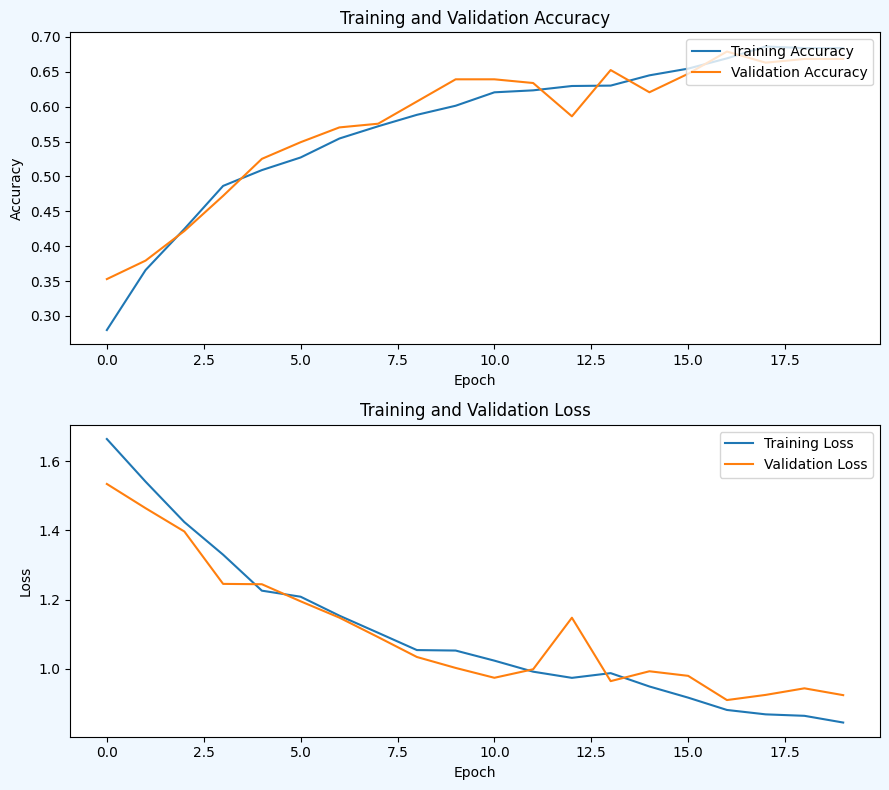

In [72]:
model_several_cnn = Sequential([
       layers.Input(shape = (256, 256, 3)),
    
        layers.Conv2D(32, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        layers.MaxPooling2D(pool_size = (2,2)),
        #layers.BatchNormalization(),
    
        layers.Conv2D(64, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        #layers.Dropout(rate=0.2),

        layers.Conv2D(128, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        
        layers.Flatten(), # layer converts all feature maps into a one-dimensional vector
        layers.Dense(128, activation='relu'),
        #layers.Dropout(rate=0.2),
        layers.Dense(len(classes), activation='softmax') # Output Classification layer
        ])

model_several_cnn.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
                          metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])
model_several_cnn.summary()
history = model_several_cnn.fit(train_ds, epochs = 20, validation_data = val_ds, callbacks = [early_stopping])
metrics_model= metrics(model_several_cnn, val_ds)
performance_plot(model_several_cnn, history)

Можна спостерігати покращення метрик: 
* Validation Loss: 0.91
* Validation Accuracy: 67.90%
* Validation Precision: 75.34%
* Validation Recall: 59.15%
* AUC: 0.92%

#### Add BatchNormalization

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_72 (Conv2D)            │ (None, 128, 128, 32)  │          416 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_72              │ (None, 64, 64, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_8         │ (None, 64, 64, 32)    │          128 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_73 (Conv2D)            │ (None, 32, 32, 64)    │        8,256 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_73              │ (None, 16, 16, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_74 (Conv2D)            │ (None, 8, 8, 128)     │       32,896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_74              │ (None, 4, 4, 128)     │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_33 (Flatten)          │ (None, 2048)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_66 (Dense)              │ (None, 128)           │      262,272 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_67 (Dense)              │ (None, 6)             │          774 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 304,742 (1.16 MB)

 Trainable params: 304,678 (1.16 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 196ms/step - accuracy: 0.3447 - auc_32: 0.6957 - loss: 1.6449 - precision_33: 0.5290 - recall_33: 0.0920 - val_accuracy: 0.2626 - val_auc_32: 0.6691 - val_loss: 1.7039 - val_precision_33: 0.0000e+00 - val_recall_33: 0.0000e+00
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 0.5461 - auc_32: 0.8418 - loss: 1.2399 - precision_33: 0.7027 - recall_33: 0.3273 - val_accuracy: 0.3767 - val_auc_32: 0.6849 - val_loss: 1.6756 - val_precision_33: 0.0000e+00 - val_recall_33: 0.0000e+00
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - accuracy: 0.5967 - auc_32: 0.8707 - loss: 1.1256 - precision_33: 0.7381 - recall_33: 0.4056 - val_accuracy: 0.2599 - val_auc_32: 0.6833 - val_loss: 1.6604 - val_precision_33: 0.0000e+00 - val_recall_33: 0.0000e+00
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - accuracy: 0.6060 - auc_32: 0.8833 - loss: 1.0747 - precision_33: 0.7564 - recall_33: 0.4449 - val_accuracy: 0.3873 - val_auc_32: 0.7349 - 

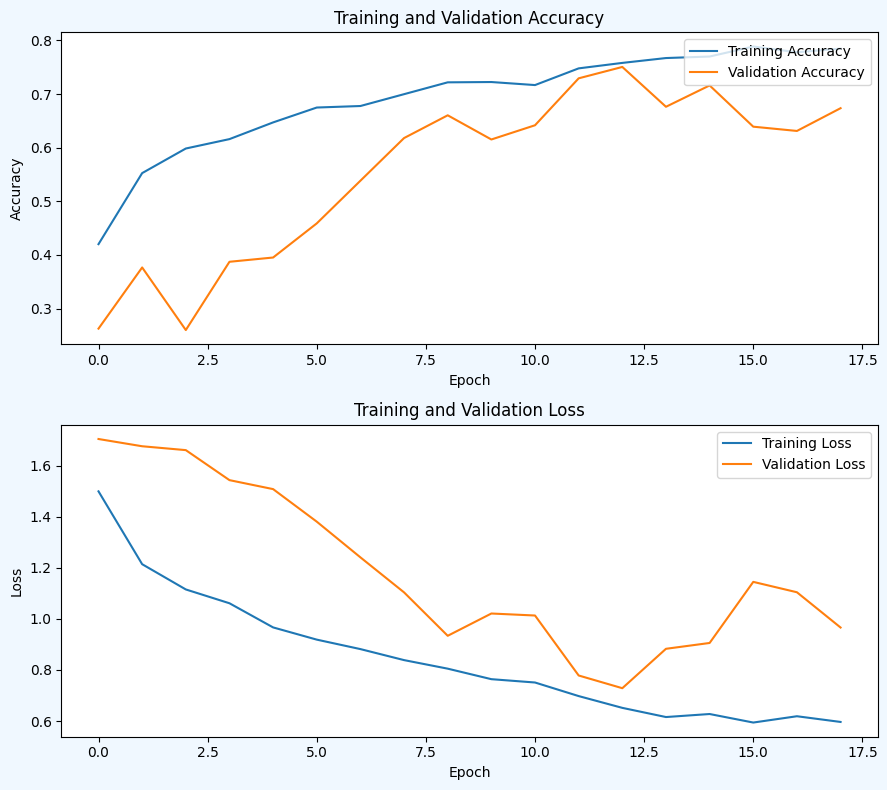

In [76]:
model_norm= Sequential([
       layers.Input(shape = (256, 256, 3)),
    
        layers.Conv2D(32, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.BatchNormalization(),
    
        layers.Conv2D(64, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        #layers.Dropout(rate=0.2),

        layers.Conv2D(128, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        
        layers.Flatten(), # layer converts all feature maps into a one-dimensional vector
        layers.Dense(128, activation='relu'),
        #layers.Dropout(rate=0.2),
        layers.Dense(len(classes), activation='softmax') # Output Classification layer
        ])

model_norm.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
                          metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])
model_norm.summary()
history = model_norm.fit(train_ds, epochs = 20, validation_data = val_ds, callbacks = [early_stopping])
metrics_model= metrics(model_norm, val_ds)
performance_plot(model_norm, history)

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_78 (Conv2D)            │ (None, 128, 128, 32)  │          416 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_78              │ (None, 64, 64, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_11        │ (None, 64, 64, 32)    │          128 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_79 (Conv2D)            │ (None, 32, 32, 64)    │        8,256 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_12        │ (None, 32, 32, 64)    │          256 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_79              │ (None, 16, 16, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_80 (Conv2D)            │ (None, 8, 8, 128)     │       32,896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_80              │ (None, 4, 4, 128)     │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_35 (Flatten)          │ (None, 2048)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_70 (Dense)              │ (None, 128)           │      262,272 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_71 (Dense)              │ (None, 6)             │          774 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 304,998 (1.16 MB)

 Trainable params: 304,806 (1.16 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 220ms/step - accuracy: 0.3707 - auc_34: 0.6959 - loss: 1.9052 - precision_35: 0.4454 - recall_35: 0.2008 - val_accuracy: 0.2387 - val_auc_34: 0.5992 - val_loss: 1.7549 - val_precision_35: 0.0000e+00 - val_recall_35: 0.0000e+00
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 207ms/step - accuracy: 0.5401 - auc_34: 0.8399 - loss: 1.2453 - precision_35: 0.7027 - recall_35: 0.3518 - val_accuracy: 0.2467 - val_auc_34: 0.6225 - val_loss: 1.8577 - val_precision_35: 1.0000 - val_recall_35: 0.0027
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 202ms/step - accuracy: 0.5949 - auc_34: 0.8746 - loss: 1.1099 - precision_35: 0.7372 - recall_35: 0.4375 - val_accuracy: 0.2387 - val_auc_34: 0.6186 - val_loss: 1.9084 - val_precision_35: 0.5472 - val_recall_35: 0.1538
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 204ms/step - accuracy: 0.6280 - auc_34: 0.8941 - loss: 1.0259 - precision_35: 0.7484 - recall_35: 0.4829 - val_accuracy: 0.2891 - val_auc_34: 0.6575 - val_loss: 1.7814

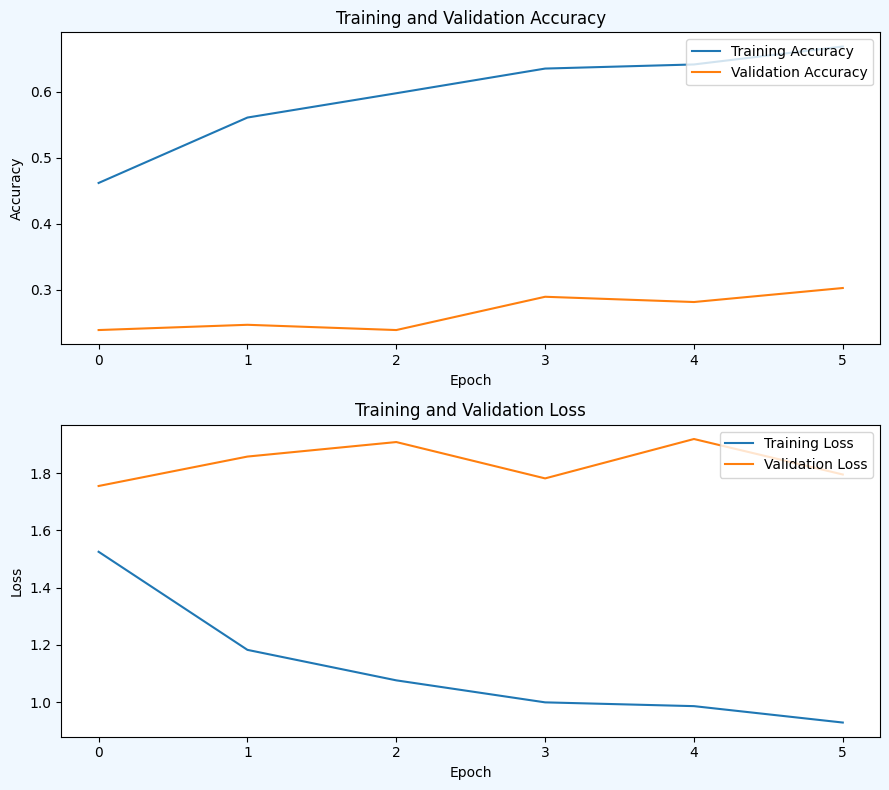

In [78]:
model_norm2 = Sequential([
       layers.Input(shape = (256, 256, 3)),
    
        layers.Conv2D(32, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.BatchNormalization(),
    
        layers.Conv2D(64, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        #layers.Dropout(rate=0.2),

        layers.Conv2D(128, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        
        layers.Flatten(), # layer converts all feature maps into a one-dimensional vector
        layers.Dense(128, activation='relu'),
        #layers.Dropout(rate=0.2),
        layers.Dense(len(classes), activation='softmax') # Output Classification layer
        ])

model_norm2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
                          metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])
model_norm2.summary()
history = model_norm2.fit(train_ds, epochs = 20, validation_data = val_ds, callbacks = [early_stopping])
metrics_model= metrics(model_norm2, val_ds)
performance_plot(model_norm2, history)

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)            │ (None, 128, 128, 32)  │          416 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_40              │ (None, 64, 64, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_3         │ (None, 64, 64, 32)    │          128 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_41 (Conv2D)            │ (None, 32, 32, 64)    │        8,256 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_4         │ (None, 32, 32, 64)    │          256 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_41              │ (None, 16, 16, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_42 (Conv2D)            │ (None, 8, 8, 128)     │       32,896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_5         │ (None, 8, 8, 128)     │          512 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_42              │ (None, 4, 4, 128)     │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_22 (Flatten)          │ (None, 2048)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_44 (Dense)              │ (None, 128)           │      262,272 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_45 (Dense)              │ (None, 6)             │          774 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 305,510 (1.17 MB)

 Trainable params: 305,062 (1.16 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 204ms/step - accuracy: 0.4244 - auc_21: 0.7455 - loss: 1.9695 - precision_22: 0.4980 - recall_22: 0.3410 - val_accuracy: 0.0531 - val_auc_21: 0.4322 - val_loss: 3.1149 - val_precision_22: 0.0531 - val_recall_22: 0.0531
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - accuracy: 0.5480 - auc_21: 0.8543 - loss: 1.2393 - precision_22: 0.6544 - recall_22: 0.4361 - val_accuracy: 0.0531 - val_auc_21: 0.4844 - val_loss: 3.7604 - val_precision_22: 0.0533 - val_recall_22: 0.0531
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.6348 - auc_21: 0.9036 - loss: 1.0066 - precision_22: 0.7193 - recall_22: 0.5239 - val_accuracy: 0.2334 - val_auc_21: 0.5677 - val_loss: 2.5162 - val_precision_22: 0.2374 - val_recall_22: 0.0875
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - accuracy: 0.6406 - auc_21: 0.9059 - loss: 0.9707 - precision_22: 0.7352 - recall_22: 0.5471 - val_accuracy: 0.3475 - val_auc_21: 0.6590 - val_loss: 2.0286 - val_p

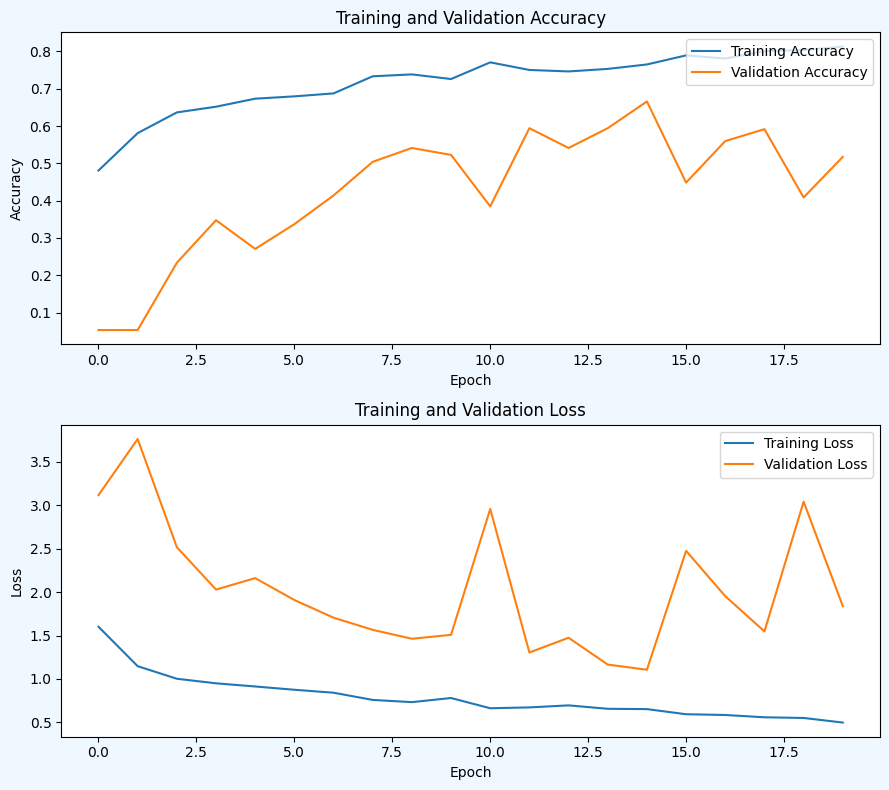

In [63]:
model_norm3 = Sequential([
       layers.Input(shape = (256, 256, 3)),
    
        layers.Conv2D(32, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.BatchNormalization(),
    
        layers.Conv2D(64, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        #layers.Dropout(rate=0.2),

        layers.Conv2D(128, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        
        layers.Flatten(), # layer converts all feature maps into a one-dimensional vector
        layers.Dense(128, activation='relu'),
        #layers.Dropout(rate=0.2),
        layers.Dense(len(classes), activation='softmax') # Output Classification layer
        ])

model_norm3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
                          metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])
model_norm3.summary()
history = model_norm3.fit(train_ds, epochs = 20, validation_data = val_ds, callbacks = [early_stopping])
performance_plot(model_norm3, history)

Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_87 (Conv2D)            │ (None, 128, 128, 32)  │          416 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_87              │ (None, 64, 64, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_17        │ (None, 64, 64, 32)    │          128 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_88 (Conv2D)            │ (None, 32, 32, 64)    │        8,256 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_88              │ (None, 16, 16, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_89 (Conv2D)            │ (None, 8, 8, 128)     │       32,896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_18        │ (None, 8, 8, 128)     │          512 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_89              │ (None, 4, 4, 128)     │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_38 (Flatten)          │ (None, 2048)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_76 (Dense)              │ (None, 128)           │      262,272 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_77 (Dense)              │ (None, 6)             │          774 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 305,254 (1.16 MB)

 Trainable params: 304,934 (1.16 MB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 204ms/step - accuracy: 0.4176 - auc_37: 0.7399 - loss: 1.8689 - precision_38: 0.4752 - recall_38: 0.3058 - val_accuracy: 0.2361 - val_auc_37: 0.6366 - val_loss: 1.8013 - val_precision_38: 0.0000e+00 - val_recall_38: 0.0000e+00
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 0.5772 - auc_37: 0.8550 - loss: 1.2221 - precision_38: 0.6905 - recall_38: 0.4406 - val_accuracy: 0.2361 - val_auc_37: 0.6376 - val_loss: 1.9658 - val_precision_38: 0.2752 - val_recall_38: 0.1883
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step - accuracy: 0.5996 - auc_37: 0.8694 - loss: 1.1462 - precision_38: 0.7173 - recall_38: 0.4582 - val_accuracy: 0.2387 - val_auc_37: 0.6524 - val_loss: 1.9704 - val_precision_38: 0.4191 - val_recall_38: 0.1512
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - accuracy: 0.6372 - auc_37: 0.8958 - loss: 1.0356 - precision_38: 0.7345 - recall_38: 0.5156 - val_accuracy: 0.2573 - val_auc_37: 0.6515 - val_loss: 2.1724

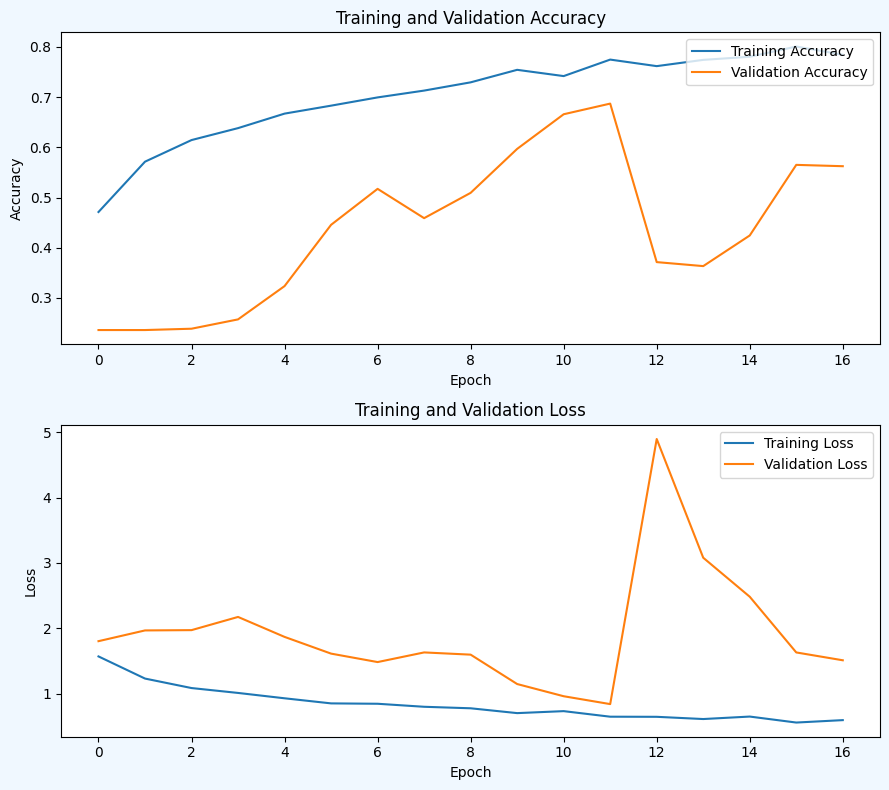

In [84]:
model_norm4 = Sequential([
       layers.Input(shape = (256, 256, 3)),
    
        layers.Conv2D(32, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.BatchNormalization(),
    
        layers.Conv2D(64, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        #layers.Dropout(rate=0.2),

        layers.Conv2D(128, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        
        layers.Flatten(), # layer converts all feature maps into a one-dimensional vector
        layers.Dense(128, activation='relu'),
        #layers.Dropout(rate=0.2),
        layers.Dense(len(classes), activation='softmax') # Output Classification layer
        ])

model_norm4.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
                          metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])
model_norm4.summary()
history = model_norm4.fit(train_ds, epochs = 20, validation_data = val_ds, callbacks = [early_stopping])
metrics_model= metrics(model_norm4, val_ds)
performance_plot(model_norm4, history)

Після додавання шару нормалізації за міні-батчами спостерігається покращення метрик якості моделі:
* Validation Loss: 0.73
* Validation Accuracy: 75.07%
* Validation Precision: 83.81%
* Validation Recall: 61.80%
* AUC: 0.95%

З додаванням більшої кількості нормалізації на згорткових шарах, видно помітне погіршення поведінки моделі, зниження точності та збільшення показників втрат. Також на графіках спостерігалось далеке розташування кривих перевірочної та навчальної множин.


Найгірша поведінка при двох перших шарах нормалізації:
* Validation Loss: 1.75
* Validation Accuracy: 23.87%
* Validation Precision: 0.00%
* Validation Recall: 0.00%
* AUC: 0.60%

#### Add Dropout

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_64 (Conv2D)            │ (None, 128, 128, 32)  │          416 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_64              │ (None, 64, 64, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_65 (Conv2D)            │ (None, 32, 32, 64)    │        8,256 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_65              │ (None, 16, 16, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_12 (Dropout)          │ (None, 16, 16, 64)    │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_66 (Conv2D)            │ (None, 8, 8, 128)     │       32,896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_66              │ (None, 4, 4, 128)     │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_30 (Flatten)          │ (None, 2048)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_60 (Dense)              │ (None, 128)           │      262,272 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_61 (Dense)              │ (None, 6)             │          774 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 304,614 (1.16 MB)

 Trainable params: 304,614 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.2284 - auc_29: 0.5962 - loss: 1.7358 - precision_30: 0.0000e+00 - recall_30: 0.0000e+00 - val_accuracy: 0.3422 - val_auc_29: 0.7232 - val_loss: 1.5800 - val_precision_30: 0.0000e+00 - val_recall_30: 0.0000e+00
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.3269 - auc_29: 0.7225 - loss: 1.5629 - precision_30: 0.6127 - recall_30: 0.0279 - val_accuracy: 0.4138 - val_auc_29: 0.7888 - val_loss: 1.4147 - val_precision_30: 0.8723 - val_recall_30: 0.1088
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.4476 - auc_29: 0.7982 - loss: 1.3706 - precision_30: 0.7825 - recall_30: 0.1752 - val_accuracy: 0.4589 - val_auc_29: 0.8119 - val_loss: 1.3501 - val_precision_30: 0.6636 - val_recall_30: 0.1883
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.4821 - auc_29: 0.8198 - loss: 1.3122 - precision_30: 0.6837 - recall_30: 0.2359 - val_accuracy: 0.5093 - val_auc_29: 0.8423 - val_loss: 1

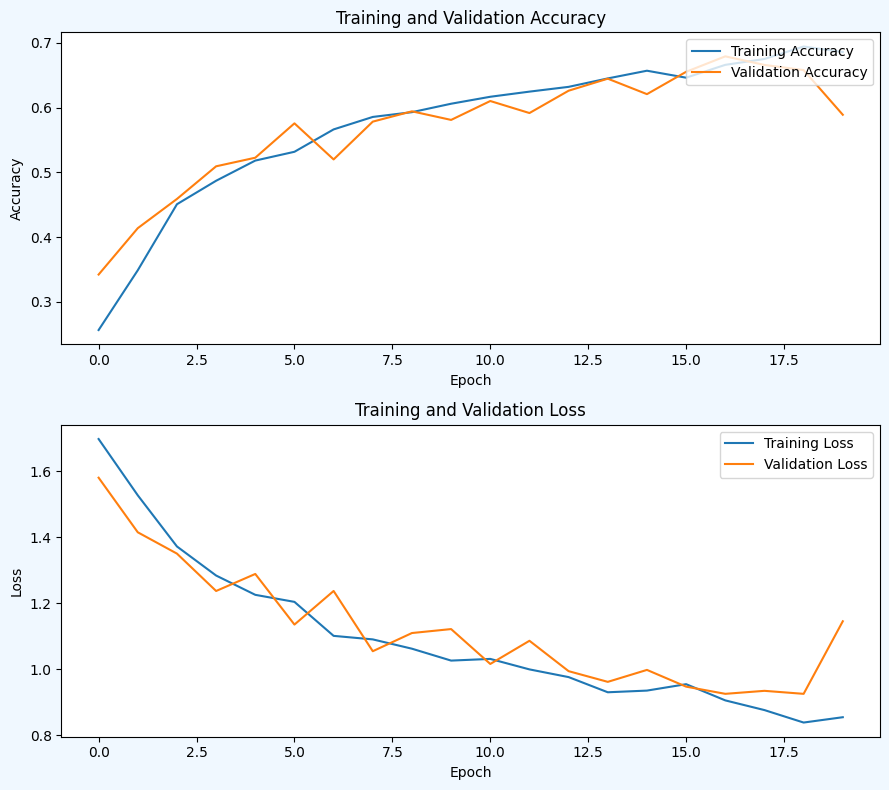

In [71]:
model_several_cnn = Sequential([
       layers.Input(shape = (256, 256, 3)),
    
        layers.Conv2D(32, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        layers.MaxPooling2D(pool_size = (2,2)),
        #layers.BatchNormalization(),
    
        layers.Conv2D(64, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.Dropout(rate=0.2),

        layers.Conv2D(128, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        
        layers.Flatten(), # layer converts all feature maps into a one-dimensional vector
        layers.Dense(128, activation='relu'),
        #layers.Dropout(rate=0.2),
        layers.Dense(len(classes), activation='softmax') # Output Classification layer
        ])

model_several_cnn.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
                          metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])
model_several_cnn.summary()
history = model_several_cnn.fit(train_ds, epochs = 20, validation_data = val_ds, callbacks = [early_stopping])
metrics_model= metrics(model_several_cnn, val_ds)
performance_plot(model_several_cnn, history)

Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_90 (Conv2D)            │ (None, 128, 128, 32)  │          416 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_90              │ (None, 64, 64, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_91 (Conv2D)            │ (None, 32, 32, 64)    │        8,256 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_91              │ (None, 16, 16, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_13 (Dropout)          │ (None, 16, 16, 64)    │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_92 (Conv2D)            │ (None, 8, 8, 128)     │       32,896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_92              │ (None, 4, 4, 128)     │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_39 (Flatten)          │ (None, 2048)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_78 (Dense)              │ (None, 128)           │      262,272 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_79 (Dense)              │ (None, 6)             │          774 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 304,614 (1.16 MB)

 Trainable params: 304,614 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step - accuracy: 0.2063 - auc_38: 0.5856 - loss: 1.7469 - precision_39: 0.0000e+00 - recall_39: 0.0000e+00 - val_accuracy: 0.3899 - val_auc_38: 0.6992 - val_loss: 1.6090 - val_precision_39: 0.6667 - val_recall_39: 0.0053
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.3393 - auc_38: 0.7013 - loss: 1.6052 - precision_39: 0.7721 - recall_39: 0.0484 - val_accuracy: 0.4483 - val_auc_38: 0.7931 - val_loss: 1.4314 - val_precision_39: 0.8222 - val_recall_39: 0.0981
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.4147 - auc_38: 0.7785 - loss: 1.4233 - precision_39: 0.7744 - recall_39: 0.1481 - val_accuracy: 0.4430 - val_auc_38: 0.8085 - val_loss: 1.3761 - val_precision_39: 0.8000 - val_recall_39: 0.0849
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 0.4606 - auc_38: 0.8051 - loss: 1.3515 - precision_39: 0.7456 - recall_39: 0.1794 - val_accuracy: 0.4642 - val_auc_38: 0.8439 - val_loss: 1.2438 - 

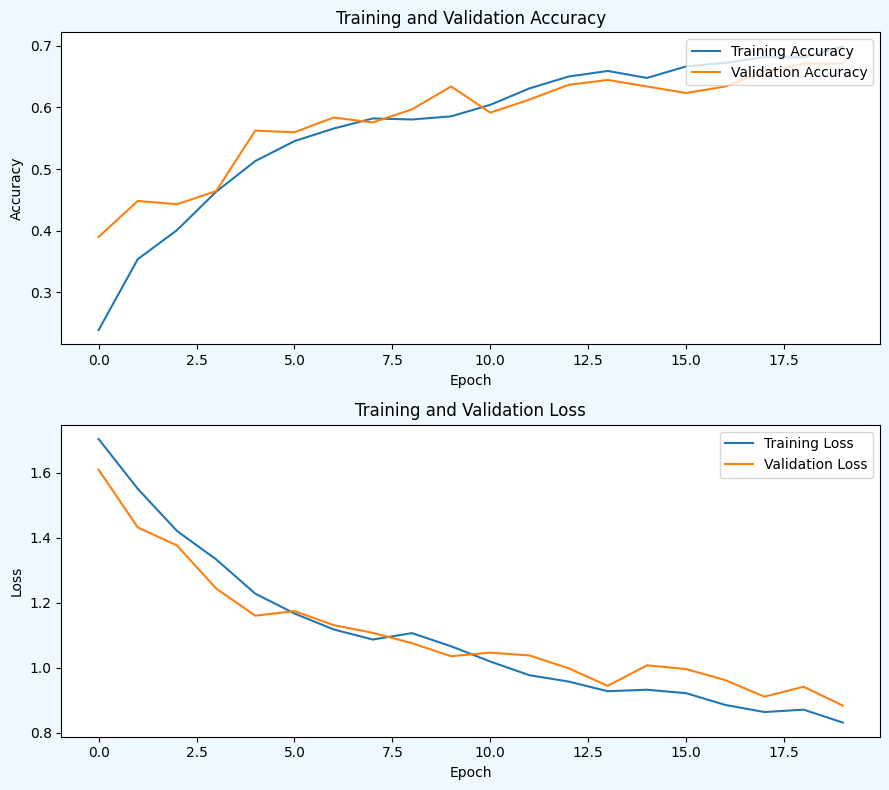

In [86]:
model_drop = Sequential([
       layers.Input(shape = (256, 256, 3)),
    
        layers.Conv2D(32, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        layers.MaxPooling2D(pool_size = (2,2)),
        #layers.BatchNormalization(),
    
        layers.Conv2D(64, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.Dropout(rate=0.3),

        layers.Conv2D(128, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        
        layers.Flatten(), # layer converts all feature maps into a one-dimensional vector
        layers.Dense(128, activation='relu'),
        #layers.Dropout(rate=0.2),
        layers.Dense(len(classes), activation='softmax') # Output Classification layer
        ])

model_drop.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
                          metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])
model_drop.summary()
history = model_drop.fit(train_ds, epochs = 20, validation_data = val_ds, callbacks = [early_stopping])
metrics_model= metrics(model_drop, val_ds)
performance_plot(model_drop, history)

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_61 (Conv2D)            │ (None, 128, 128, 32)  │          416 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_61              │ (None, 64, 64, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_62 (Conv2D)            │ (None, 32, 32, 64)    │        8,256 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_62              │ (None, 16, 16, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_63 (Conv2D)            │ (None, 8, 8, 128)     │       32,896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_63              │ (None, 4, 4, 128)     │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_29 (Flatten)          │ (None, 2048)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_58 (Dense)              │ (None, 128)           │      262,272 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_11 (Dropout)          │ (None, 128)           │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_59 (Dense)              │ (None, 6)             │          774 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 304,614 (1.16 MB)

 Trainable params: 304,614 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.2362 - auc_28: 0.6026 - loss: 1.7381 - precision_29: 0.8947 - recall_29: 0.0013 - val_accuracy: 0.3342 - val_auc_28: 0.6983 - val_loss: 1.6110 - val_precision_29: 0.0000e+00 - val_recall_29: 0.0000e+00
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.3597 - auc_28: 0.7192 - loss: 1.5705 - precision_29: 0.6174 - recall_29: 0.0484 - val_accuracy: 0.4271 - val_auc_28: 0.7992 - val_loss: 1.3671 - val_precision_29: 0.7937 - val_recall_29: 0.1326
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.4517 - auc_28: 0.7999 - loss: 1.3705 - precision_29: 0.7282 - recall_29: 0.1821 - val_accuracy: 0.5066 - val_auc_28: 0.8395 - val_loss: 1.2480 - val_precision_29: 0.7273 - val_recall_29: 0.2122
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.5133 - auc_28: 0.8321 - loss: 1.2710 - precision_29: 0.7356 - recall_29: 0.2810 - val_accuracy: 0.5411 - val_auc_28: 0.8660 - val_loss: 1.1529 - 

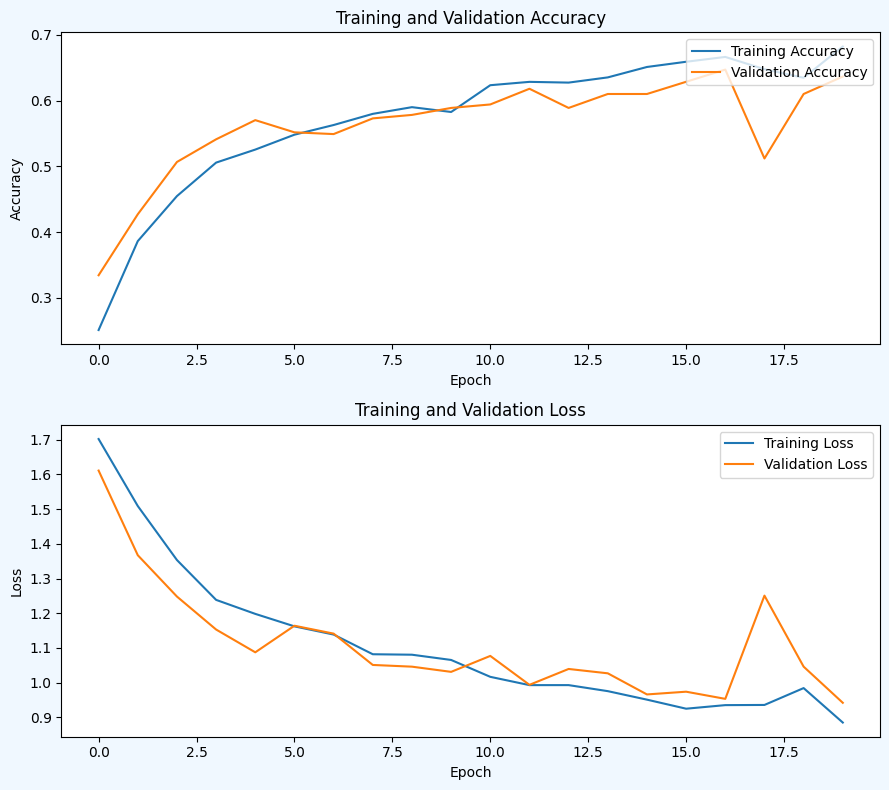

In [70]:
model_several_cnn = Sequential([
       layers.Input(shape = (256, 256, 3)),
    
        layers.Conv2D(32, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        layers.MaxPooling2D(pool_size = (2,2)),
        #layers.BatchNormalization(),
    
        layers.Conv2D(64, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        #layers.Dropout(rate=0.2),

        layers.Conv2D(128, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        
        layers.Flatten(), # layer converts all feature maps into a one-dimensional vector
        layers.Dense(128, activation='relu'),
        layers.Dropout(rate=0.2),
        layers.Dense(len(classes), activation='softmax') # Output Classification layer
        ])

model_several_cnn.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
                          metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])
model_several_cnn.summary()
history = model_several_cnn.fit(train_ds, epochs = 20, validation_data = val_ds, callbacks = [early_stopping])
metrics_model= metrics(model_several_cnn, val_ds)
performance_plot(model_several_cnn, history)

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_93 (Conv2D)            │ (None, 128, 128, 32)  │          416 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_93              │ (None, 64, 64, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_94 (Conv2D)            │ (None, 32, 32, 64)    │        8,256 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_94              │ (None, 16, 16, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_95 (Conv2D)            │ (None, 8, 8, 128)     │       32,896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_95              │ (None, 4, 4, 128)     │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_40 (Flatten)          │ (None, 2048)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_80 (Dense)              │ (None, 128)           │      262,272 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_14 (Dropout)          │ (None, 128)           │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_81 (Dense)              │ (None, 6)             │          774 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 304,614 (1.16 MB)

 Trainable params: 304,614 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 0.2109 - auc_39: 0.5900 - loss: 1.7485 - precision_40: 0.0000e+00 - recall_40: 0.0000e+00 - val_accuracy: 0.2361 - val_auc_39: 0.6752 - val_loss: 1.6325 - val_precision_40: 0.0000e+00 - val_recall_40: 0.0000e+00
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.2943 - auc_39: 0.6996 - loss: 1.6072 - precision_40: 0.5133 - recall_40: 0.0130 - val_accuracy: 0.3926 - val_auc_39: 0.7719 - val_loss: 1.4486 - val_precision_40: 0.8182 - val_recall_40: 0.0477
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.3851 - auc_39: 0.7604 - loss: 1.4903 - precision_40: 0.7536 - recall_40: 0.0757 - val_accuracy: 0.4642 - val_auc_39: 0.8198 - val_loss: 1.3057 - val_precision_40: 0.7634 - val_recall_40: 0.1883
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.4608 - auc_39: 0.7979 - loss: 1.3939 - precision_40: 0.6624 - recall_40: 0.1807 - val_accuracy: 0.4801 - val_auc_39: 0.8325 - val_loss

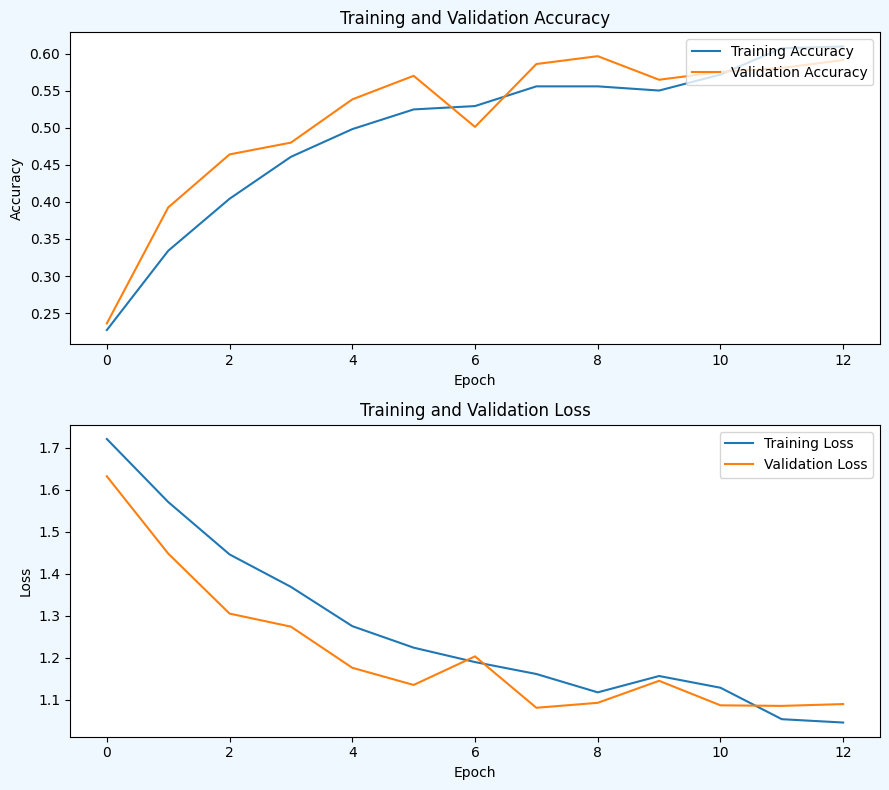

In [87]:
model_drop = Sequential([
       layers.Input(shape = (256, 256, 3)),
    
        layers.Conv2D(32, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        layers.MaxPooling2D(pool_size = (2,2)),
        #layers.BatchNormalization(),
    
        layers.Conv2D(64, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        #layers.Dropout(rate=0.2),

        layers.Conv2D(128, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        
        layers.Flatten(), # layer converts all feature maps into a one-dimensional vector
        layers.Dense(128, activation='relu'),
        layers.Dropout(rate=0.3),
        layers.Dense(len(classes), activation='softmax') # Output Classification layer
        ])

model_drop.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
                          metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])
model_drop.summary()
history = model_drop.fit(train_ds, epochs = 20, validation_data = val_ds, callbacks = [early_stopping])
metrics_model= metrics(model_drop, val_ds)
performance_plot(model_drop, history)

Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_102 (Conv2D)           │ (None, 128, 128, 32)  │          416 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_102             │ (None, 64, 64, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_103 (Conv2D)           │ (None, 32, 32, 64)    │        8,256 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_103             │ (None, 16, 16, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_104 (Conv2D)           │ (None, 8, 8, 128)     │       32,896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_104             │ (None, 4, 4, 128)     │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_43 (Flatten)          │ (None, 2048)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_86 (Dense)              │ (None, 128)           │      262,272 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_18 (Dropout)          │ (None, 128)           │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_87 (Dense)              │ (None, 6)             │          774 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 304,614 (1.16 MB)

 Trainable params: 304,614 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - accuracy: 0.2276 - auc_42: 0.6098 - loss: 1.7285 - precision_43: 0.0352 - recall_43: 1.5422e-04 - val_accuracy: 0.3103 - val_auc_42: 0.7067 - val_loss: 1.5903 - val_precision_43: 0.5000 - val_recall_43: 0.0027
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.3452 - auc_42: 0.7246 - loss: 1.5604 - precision_43: 0.7360 - recall_43: 0.0403 - val_accuracy: 0.4377 - val_auc_42: 0.7833 - val_loss: 1.4159 - val_precision_43: 0.8222 - val_recall_43: 0.0981
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.4336 - auc_42: 0.7757 - loss: 1.4431 - precision_43: 0.7247 - recall_43: 0.1464 - val_accuracy: 0.4589 - val_auc_42: 0.8251 - val_loss: 1.3071 - val_precision_43: 0.7374 - val_recall_43: 0.1936
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 0.4681 - auc_42: 0.8113 - loss: 1.3459 - precision_43: 0.7229 - recall_43: 0.2075 - val_accuracy: 0.4854 - val_auc_42: 0.8400 - val_loss: 1.2460 - val_

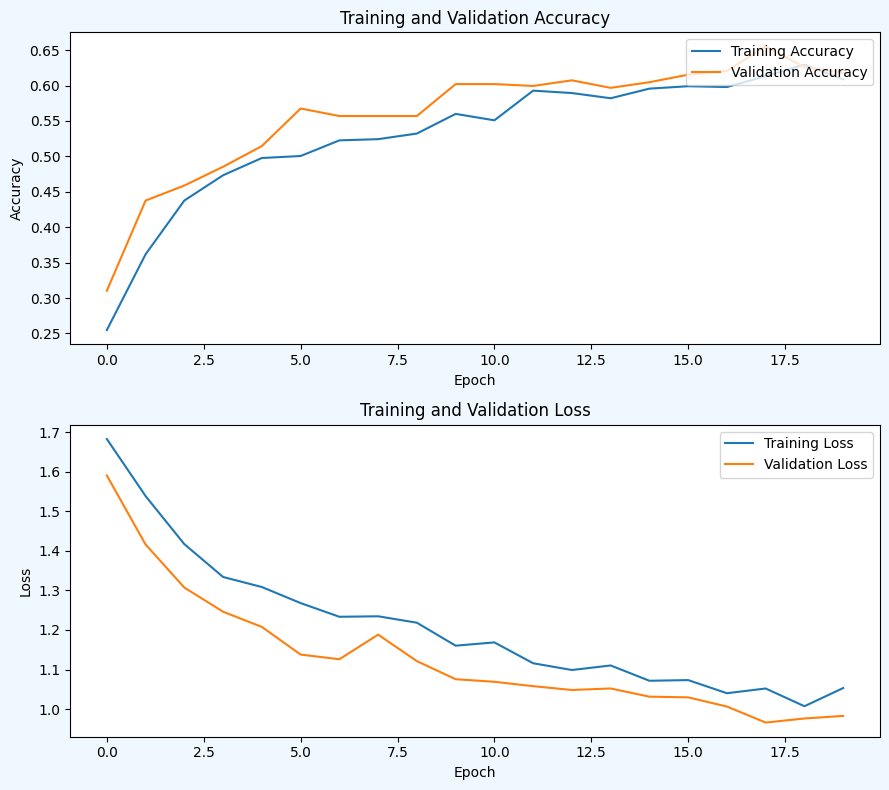

In [90]:
model_drop = Sequential([
       layers.Input(shape = (256, 256, 3)),
    
        layers.Conv2D(32, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        layers.MaxPooling2D(pool_size = (2,2)),
        #layers.BatchNormalization(),
    
        layers.Conv2D(64, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        #layers.Dropout(rate=0.2),

        layers.Conv2D(128, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        
        layers.Flatten(), # layer converts all feature maps into a one-dimensional vector
        layers.Dense(128, activation='relu'),
        layers.Dropout(rate=0.5),
        layers.Dense(len(classes), activation='softmax') # Output Classification layer
        ])

model_drop.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
                          metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])
model_drop.summary()
history = model_drop.fit(train_ds, epochs = 20, validation_data = val_ds, callbacks = [early_stopping])
metrics_model= metrics(model_drop, val_ds)
performance_plot(model_drop, history)

Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_99 (Conv2D)            │ (None, 128, 128, 32)  │          416 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_99              │ (None, 64, 64, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_100 (Conv2D)           │ (None, 32, 32, 64)    │        8,256 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_100             │ (None, 16, 16, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_16 (Dropout)          │ (None, 16, 16, 64)    │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_101 (Conv2D)           │ (None, 8, 8, 128)     │       32,896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_101             │ (None, 4, 4, 128)     │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_42 (Flatten)          │ (None, 2048)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_84 (Dense)              │ (None, 128)           │      262,272 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_17 (Dropout)          │ (None, 128)           │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_85 (Dense)              │ (None, 6)             │          774 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 304,614 (1.16 MB)

 Trainable params: 304,614 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 0.2071 - auc_41: 0.5867 - loss: 1.7478 - precision_42: 0.0000e+00 - recall_42: 0.0000e+00 - val_accuracy: 0.2865 - val_auc_41: 0.7011 - val_loss: 1.6091 - val_precision_42: 0.0000e+00 - val_recall_42: 0.0000e+00
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 0.3391 - auc_41: 0.7180 - loss: 1.5765 - precision_42: 0.5898 - recall_42: 0.0237 - val_accuracy: 0.4032 - val_auc_41: 0.7827 - val_loss: 1.4438 - val_precision_42: 0.9500 - val_recall_42: 0.0504
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.4125 - auc_41: 0.7680 - loss: 1.4490 - precision_42: 0.8215 - recall_42: 0.1256 - val_accuracy: 0.4509 - val_auc_41: 0.8068 - val_loss: 1.3379 - val_precision_42: 0.7143 - val_recall_42: 0.1724
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 0.4391 - auc_41: 0.7951 - loss: 1.3940 - precision_42: 0.6936 - recall_42: 0.1695 - val_accuracy: 0.4934 - val_auc_41: 0.8264 - val_loss: 1

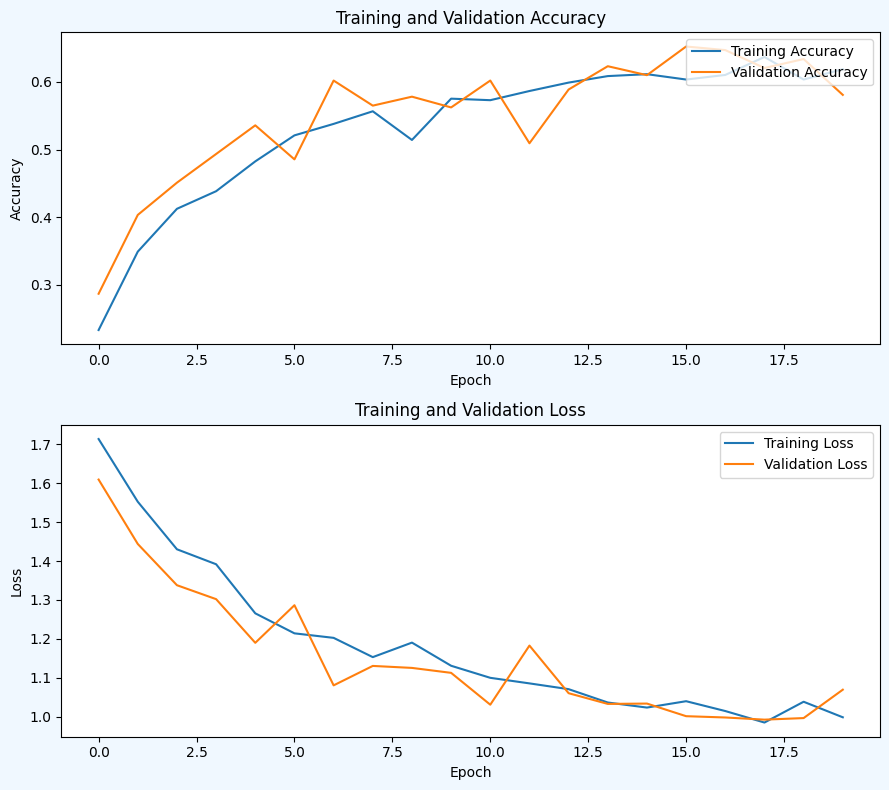

In [89]:
model_drop = Sequential([
       layers.Input(shape = (256, 256, 3)),
    
        layers.Conv2D(32, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        layers.MaxPooling2D(pool_size = (2,2)),
        #layers.BatchNormalization(),
    
        layers.Conv2D(64, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.Dropout(rate=0.2),

        layers.Conv2D(128, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        
        layers.Flatten(), # layer converts all feature maps into a one-dimensional vector
        layers.Dense(128, activation='relu'),
        layers.Dropout(rate=0.2),
        layers.Dense(len(classes), activation='softmax') # Output Classification layer
        ])

model_drop.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
                          metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])
model_drop.summary()
history = model_drop.fit(train_ds, epochs = 20, validation_data = val_ds, callbacks = [early_stopping])
metrics_model= metrics(model_drop, val_ds)
performance_plot(model_drop, history)

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_105 (Conv2D)           │ (None, 128, 128, 32)  │          416 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_105             │ (None, 64, 64, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_106 (Conv2D)           │ (None, 32, 32, 64)    │        8,256 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_106             │ (None, 16, 16, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_19 (Dropout)          │ (None, 16, 16, 64)    │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_107 (Conv2D)           │ (None, 8, 8, 128)     │       32,896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_107             │ (None, 4, 4, 128)     │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_44 (Flatten)          │ (None, 2048)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_88 (Dense)              │ (None, 128)           │      262,272 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_20 (Dropout)          │ (None, 128)           │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_89 (Dense)              │ (None, 6)             │          774 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 304,614 (1.16 MB)

 Trainable params: 304,614 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step - accuracy: 0.1966 - auc_43: 0.5772 - loss: 1.7771 - precision_44: 0.0000e+00 - recall_44: 0.0000e+00 - val_accuracy: 0.2440 - val_auc_43: 0.6814 - val_loss: 1.7091 - val_precision_44: 0.0000e+00 - val_recall_44: 0.0000e+00
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 0.2326 - auc_43: 0.6514 - loss: 1.6798 - precision_44: 0.1001 - recall_44: 5.2464e-04 - val_accuracy: 0.3740 - val_auc_43: 0.7146 - val_loss: 1.6155 - val_precision_44: 0.0000e+00 - val_recall_44: 0.0000e+00
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.3329 - auc_43: 0.7171 - loss: 1.5835 - precision_44: 0.5193 - recall_44: 0.0128 - val_accuracy: 0.4032 - val_auc_43: 0.7558 - val_loss: 1.5131 - val_precision_44: 0.7714 - val_recall_44: 0.0716
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.3670 - auc_43: 0.7376 - loss: 1.5316 - precision_44: 0.6895 - recall_44: 0.0794 - val_accuracy: 0.4164 - val_auc_43: 0.7848 -

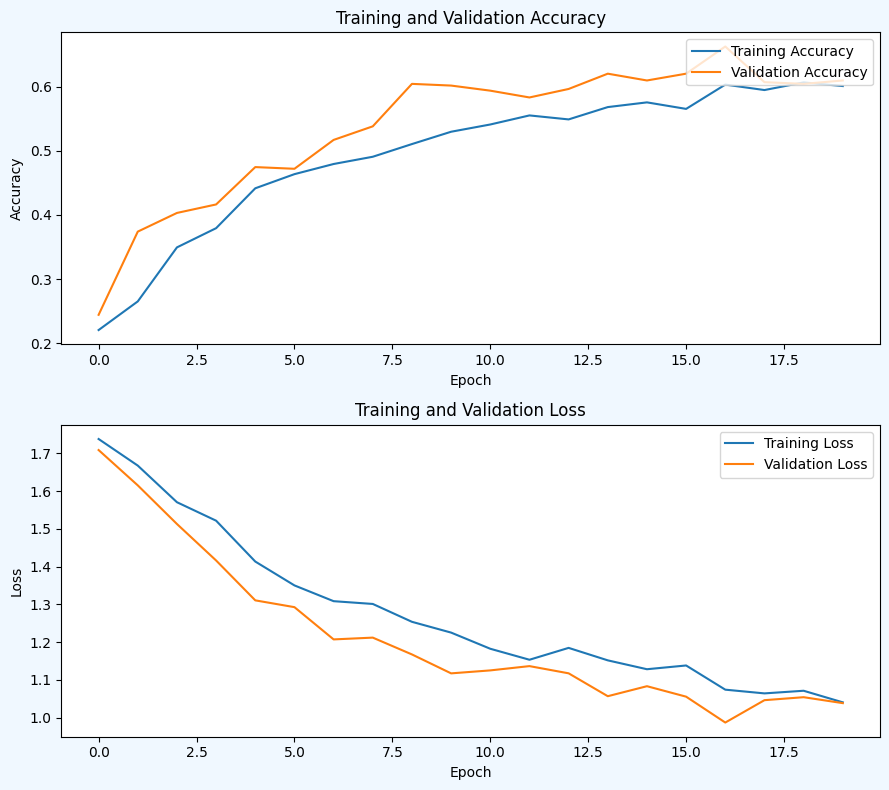

In [91]:
model_drop = Sequential([
       layers.Input(shape = (256, 256, 3)),
    
        layers.Conv2D(32, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        layers.MaxPooling2D(pool_size = (2,2)),
        #layers.BatchNormalization(),
    
        layers.Conv2D(64, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.Dropout(rate=0.3),

        layers.Conv2D(128, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        
        layers.Flatten(), # layer converts all feature maps into a one-dimensional vector
        layers.Dense(128, activation='relu'),
        layers.Dropout(rate=0.4),
        layers.Dense(len(classes), activation='softmax') # Output Classification layer
        ])

model_drop.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
                          metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])
model_drop.summary()
history = model_drop.fit(train_ds, epochs = 20, validation_data = val_ds, callbacks = [early_stopping])
metrics_model= metrics(model_drop, val_ds)
performance_plot(model_drop, history)

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_108 (Conv2D)           │ (None, 128, 128, 32)  │          416 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_108             │ (None, 64, 64, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_109 (Conv2D)           │ (None, 32, 32, 64)    │        8,256 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_109             │ (None, 16, 16, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_21 (Dropout)          │ (None, 16, 16, 64)    │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_110 (Conv2D)           │ (None, 8, 8, 128)     │       32,896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_110             │ (None, 4, 4, 128)     │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_45 (Flatten)          │ (None, 2048)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_90 (Dense)              │ (None, 128)           │      262,272 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_22 (Dropout)          │ (None, 128)           │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_91 (Dense)              │ (None, 6)             │          774 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 304,614 (1.16 MB)

 Trainable params: 304,614 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 0.2312 - auc_44: 0.5944 - loss: 1.7412 - precision_45: 0.0000e+00 - recall_45: 0.0000e+00 - val_accuracy: 0.3687 - val_auc_44: 0.7361 - val_loss: 1.5945 - val_precision_45: 0.0000e+00 - val_recall_45: 0.0000e+00
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.3466 - auc_44: 0.7064 - loss: 1.5977 - precision_45: 0.7230 - recall_45: 0.0165 - val_accuracy: 0.4138 - val_auc_44: 0.7596 - val_loss: 1.4941 - val_precision_45: 0.9167 - val_recall_45: 0.0292
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.4017 - auc_44: 0.7609 - loss: 1.4804 - precision_45: 0.7040 - recall_45: 0.0880 - val_accuracy: 0.4403 - val_auc_44: 0.8112 - val_loss: 1.3634 - val_precision_45: 0.8923 - val_recall_45: 0.1538
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.4304 - auc_44: 0.7898 - loss: 1.3963 - precision_45: 0.7322 - recall_45: 0.1509 - val_accuracy: 0.4509 - val_auc_44: 0.8214 - val_loss: 1

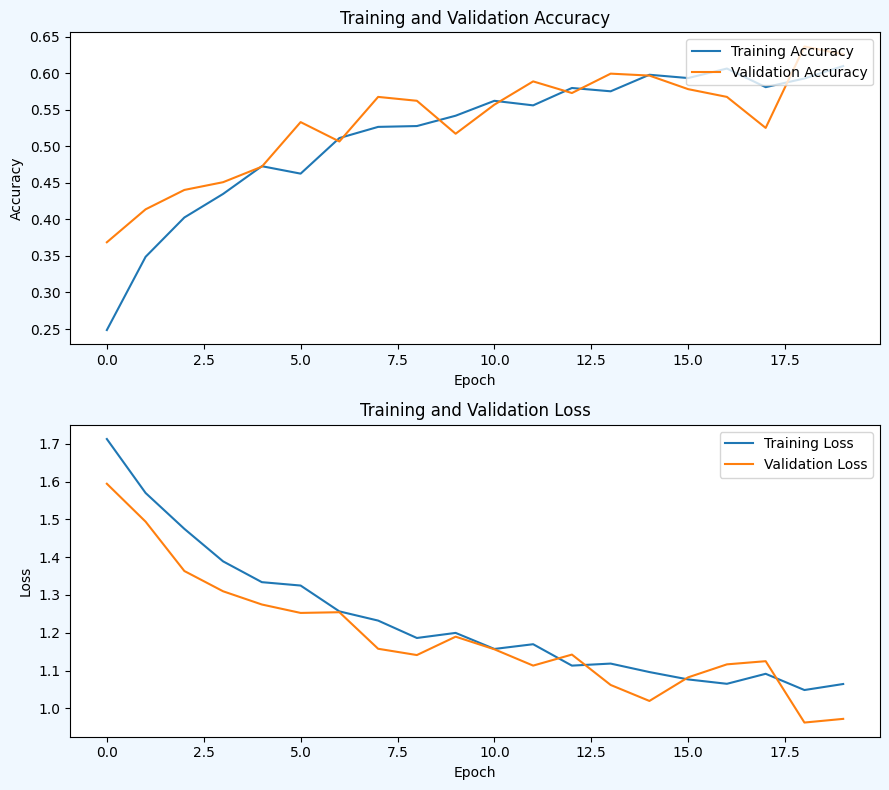

In [92]:
model_drop = Sequential([
       layers.Input(shape = (256, 256, 3)),
    
        layers.Conv2D(32, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        layers.MaxPooling2D(pool_size = (2,2)),
        #layers.BatchNormalization(),
    
        layers.Conv2D(64, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.Dropout(rate=0.2),

        layers.Conv2D(128, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        
        layers.Flatten(), # layer converts all feature maps into a one-dimensional vector
        layers.Dense(128, activation='relu'),
        layers.Dropout(rate=0.5),
        layers.Dense(len(classes), activation='softmax') # Output Classification layer
        ])

model_drop.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
                          metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])
model_drop.summary()
history = model_drop.fit(train_ds, epochs = 20, validation_data = val_ds, callbacks = [early_stopping])
metrics_model= metrics(model_drop, val_ds)
performance_plot(model_drop, history)

* При доданому шару дропауту на другому згортковому шарі спостерігається зниження точності, з val_accuracy = 65.78% для rate=0.2 та трохи краще val_accuracy = 67.11% для rate=0.3

* При 30% дропу другого згорткового шару модель мала помітно гіршу поведінку:  Validation Loss: 1.08;  Validation Accuracy: 58.62%.  При збільшенні rate=0.4 та rate=0.5 спостерігається збільшення точності та зменшення функції втрат.

* При різних комбінацій розташування декількох шарів дропауту, оказники точності інших моделей коливалися між 62%-67%.

Найкраща модель з другим згортовим шаром дропауту, при rate=0.3:
* Validation Loss: 0.88
* Validation Accuracy: 67.11%
* Validation Precision: 73.93%
* Validation Recall: 59.42%
* AUC: 0.92%

### Add Batch Normalization and Dropout

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_120 (Conv2D)           │ (None, 128, 128, 32)  │          416 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_120             │ (None, 64, 64, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_22        │ (None, 64, 64, 32)    │          128 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_121 (Conv2D)           │ (None, 32, 32, 64)    │        8,256 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_121             │ (None, 16, 16, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_26 (Dropout)          │ (None, 16, 16, 64)    │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_122 (Conv2D)           │ (None, 8, 8, 128)     │       32,896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_122             │ (None, 4, 4, 128)     │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_49 (Flatten)          │ (None, 2048)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_98 (Dense)              │ (None, 128)           │      262,272 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_99 (Dense)              │ (None, 6)             │          774 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 304,742 (1.16 MB)

 Trainable params: 304,678 (1.16 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 203ms/step - accuracy: 0.3818 - auc_48: 0.7204 - loss: 1.5733 - precision_49: 0.6271 - recall_49: 0.1211 - val_accuracy: 0.2361 - val_auc_48: 0.6705 - val_loss: 1.7348 - val_precision_49: 0.0000e+00 - val_recall_49: 0.0000e+00
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.5119 - auc_48: 0.8339 - loss: 1.2677 - precision_49: 0.6987 - recall_49: 0.2936 - val_accuracy: 0.3660 - val_auc_48: 0.7177 - val_loss: 1.6953 - val_precision_49: 0.0000e+00 - val_recall_49: 0.0000e+00
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - accuracy: 0.5707 - auc_48: 0.8726 - loss: 1.1205 - precision_49: 0.7265 - recall_49: 0.3892 - val_accuracy: 0.4589 - val_auc_48: 0.7650 - val_loss: 1.6270 - val_precision_49: 0.0000e+00 - val_recall_49: 0.0000e+00
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - accuracy: 0.5816 - auc_48: 0.8749 - loss: 1.1116 - precision_49: 0.7087 - recall_49: 0.4153 - val_accuracy: 0.4801 - val_auc_48: 0.8038 - 

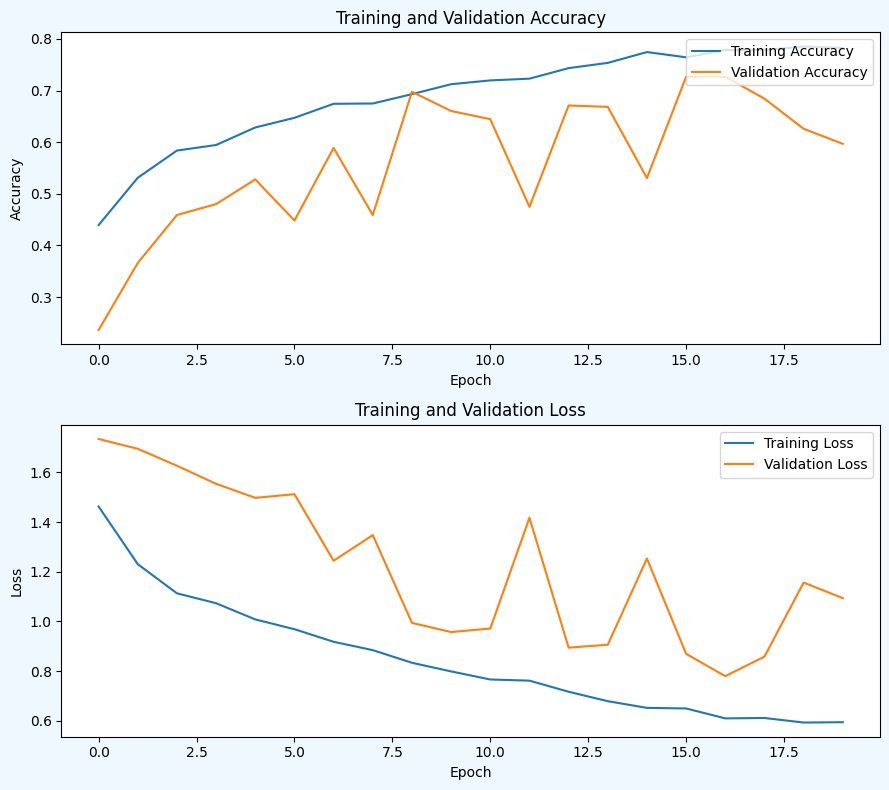

In [96]:
model_norm_batch = Sequential([
       layers.Input(shape = (256, 256, 3)),
    
        layers.Conv2D(32, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.BatchNormalization(),
    
        layers.Conv2D(64, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.Dropout(rate=0.2),

        layers.Conv2D(128, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        
        layers.Flatten(), # layer converts all feature maps into a one-dimensional vector
        layers.Dense(128, activation='relu'),
        #layers.Dropout(rate=0.2),
        layers.Dense(len(classes), activation='softmax') # Output Classification layer
        ])

model_norm_batch.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
                          metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])
model_norm_batch.summary()
history = model_norm_batch.fit(train_ds, epochs = 20, validation_data = val_ds, callbacks = [early_stopping])
metrics_model= metrics(model_norm_batch, val_ds)
performance_plot(model_norm_batch, history)

#### Let`s evaluate on more epochs

Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_126 (Conv2D)           │ (None, 128, 128, 32)  │          416 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_126             │ (None, 64, 64, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_24        │ (None, 64, 64, 32)    │          128 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_127 (Conv2D)           │ (None, 32, 32, 64)    │        8,256 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_127             │ (None, 16, 16, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_28 (Dropout)          │ (None, 16, 16, 64)    │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_128 (Conv2D)           │ (None, 8, 8, 128)     │       32,896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_128             │ (None, 4, 4, 128)     │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_51 (Flatten)          │ (None, 2048)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_102 (Dense)             │ (None, 128)           │      262,272 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_103 (Dense)             │ (None, 6)             │          774 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 304,742 (1.16 MB)

 Trainable params: 304,678 (1.16 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - accuracy: 0.3557 - auc_50: 0.7033 - loss: 1.6164 - precision_51: 0.6171 - recall_51: 0.1137 - val_accuracy: 0.2387 - val_auc_50: 0.6641 - val_loss: 1.7201 - val_precision_51: 0.0000e+00 - val_recall_51: 0.0000e+00
Epoch 2/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - accuracy: 0.5283 - auc_50: 0.8415 - loss: 1.2433 - precision_51: 0.7044 - recall_51: 0.3047 - val_accuracy: 0.2387 - val_auc_50: 0.6661 - val_loss: 1.7049 - val_precision_51: 0.0000e+00 - val_recall_51: 0.0000e+00
Epoch 3/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - accuracy: 0.5728 - auc_50: 0.8595 - loss: 1.1720 - precision_51: 0.7279 - recall_51: 0.3711 - val_accuracy: 0.3660 - val_auc_50: 0.6936 - val_loss: 1.6469 - val_precision_51: 0.0000e+00 - val_recall_51: 0.0000e+00
Epoch 4/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - accuracy: 0.5770 - auc_50: 0.8783 - loss: 1.0963 - precision_51: 0.7261 - recall_51: 0.4297 - val_accuracy: 0.4589 - val_auc_50: 0.7724 - 

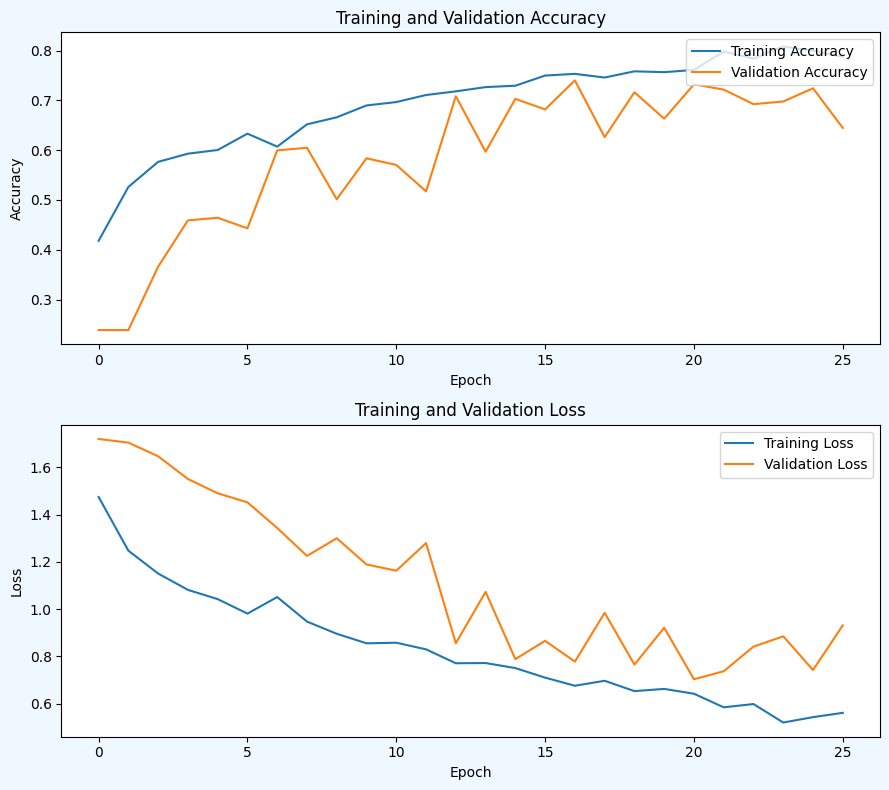

In [98]:
model_norm_batch = Sequential([
       layers.Input(shape = (256, 256, 3)),
    
        layers.Conv2D(32, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.BatchNormalization(),
    
        layers.Conv2D(64, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.Dropout(rate=0.3),

        layers.Conv2D(128, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        
        layers.Flatten(), # layer converts all feature maps into a one-dimensional vector
        layers.Dense(128, activation='relu'),
        #layers.Dropout(rate=0.2),
        layers.Dense(len(classes), activation='softmax') # Output Classification layer
        ])

model_norm_batch.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
                          metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])
model_norm_batch.summary()
history = model_norm_batch.fit(train_ds, epochs = 40, validation_data = val_ds, callbacks = [early_stopping])
metrics_model= metrics(model_norm_batch, val_ds)
performance_plot(model_norm_batch, history)

Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_132 (Conv2D)           │ (None, 128, 128, 32)  │          416 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_132             │ (None, 64, 64, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_26        │ (None, 64, 64, 32)    │          128 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_133 (Conv2D)           │ (None, 32, 32, 64)    │        8,256 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_133             │ (None, 16, 16, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_30 (Dropout)          │ (None, 16, 16, 64)    │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_134 (Conv2D)           │ (None, 8, 8, 128)     │       32,896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_27        │ (None, 8, 8, 128)     │          512 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_134             │ (None, 4, 4, 128)     │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_53 (Flatten)          │ (None, 2048)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_106 (Dense)             │ (None, 128)           │      262,272 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_107 (Dense)             │ (None, 6)             │          774 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 305,254 (1.16 MB)

 Trainable params: 304,934 (1.16 MB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 288ms/step - accuracy: 0.3582 - auc_52: 0.6877 - loss: 2.2359 - precision_53: 0.4029 - recall_53: 0.2345 - val_accuracy: 0.2361 - val_auc_52: 0.5914 - val_loss: 1.9300 - val_precision_53: 0.7895 - val_recall_53: 0.0398
Epoch 2/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 199ms/step - accuracy: 0.5187 - auc_52: 0.8234 - loss: 1.3298 - precision_53: 0.6418 - recall_53: 0.3255 - val_accuracy: 0.2334 - val_auc_52: 0.6072 - val_loss: 2.1440 - val_precision_53: 0.3668 - val_recall_53: 0.1936
Epoch 3/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.5596 - auc_52: 0.8589 - loss: 1.1957 - precision_53: 0.6917 - recall_53: 0.4186 - val_accuracy: 0.2016 - val_auc_52: 0.6129 - val_loss: 2.5803 - val_precision_53: 0.1984 - val_recall_53: 0.1963
Epoch 4/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - accuracy: 0.5908 - auc_52: 0.8808 - loss: 1.1109 - precision_53: 0.6998 - recall_53: 0.4571 - val_accuracy: 0.2016 - val_auc_52: 0.6255 - val_loss: 2.9612 - val_p

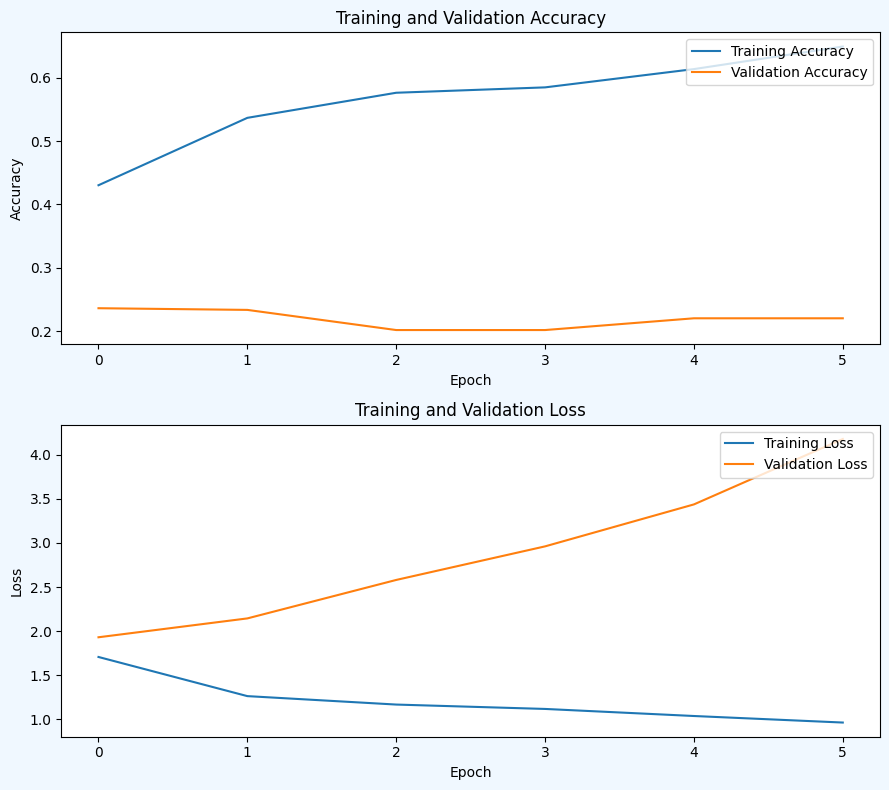

In [101]:
model_norm_batch = Sequential([
       layers.Input(shape = (256, 256, 3)),
    
        layers.Conv2D(32, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.BatchNormalization(),
    
        layers.Conv2D(64, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.Dropout(rate=0.3),

        layers.Conv2D(128, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        
        layers.Flatten(), # layer converts all feature maps into a one-dimensional vector
        layers.Dense(128, activation='relu'),
        #layers.Dropout(rate=0.2),
        layers.Dense(len(classes), activation='softmax') # Output Classification layer
        ])

model_norm_batch.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
                          metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])
model_norm_batch.summary()
history = model_norm_batch.fit(train_ds, epochs = 40, validation_data = val_ds, callbacks = [early_stopping])
metrics_model= metrics(model_norm_batch, val_ds)
performance_plot(model_norm_batch, history)

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_114 (Conv2D)           │ (None, 128, 128, 32)  │          416 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_114             │ (None, 64, 64, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_20        │ (None, 64, 64, 32)    │          128 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_115 (Conv2D)           │ (None, 32, 32, 64)    │        8,256 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_115             │ (None, 16, 16, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_116 (Conv2D)           │ (None, 8, 8, 128)     │       32,896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_116             │ (None, 4, 4, 128)     │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_47 (Flatten)          │ (None, 2048)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_94 (Dense)              │ (None, 128)           │      262,272 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_24 (Dropout)          │ (None, 128)           │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_95 (Dense)              │ (None, 6)             │          774 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 304,742 (1.16 MB)

 Trainable params: 304,678 (1.16 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step - accuracy: 0.3188 - auc_46: 0.6752 - loss: 1.6850 - precision_47: 0.4219 - recall_47: 0.0516 - val_accuracy: 0.2361 - val_auc_46: 0.6781 - val_loss: 1.7336 - val_precision_47: 0.0000e+00 - val_recall_47: 0.0000e+00
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step - accuracy: 0.4852 - auc_46: 0.8019 - loss: 1.3734 - precision_47: 0.6871 - recall_47: 0.2175 - val_accuracy: 0.4058 - val_auc_46: 0.7207 - val_loss: 1.6773 - val_precision_47: 0.0000e+00 - val_recall_47: 0.0000e+00
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 0.5410 - auc_46: 0.8312 - loss: 1.2734 - precision_47: 0.7415 - recall_47: 0.2805 - val_accuracy: 0.3820 - val_auc_46: 0.7100 - val_loss: 1.6392 - val_precision_47: 0.0000e+00 - val_recall_47: 0.0000e+00
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 0.5686 - auc_46: 0.8552 - loss: 1.1876 - precision_47: 0.7431 - recall_47: 0.3694 - val_accuracy: 0.3448 - val_auc_46: 0.7182 - 

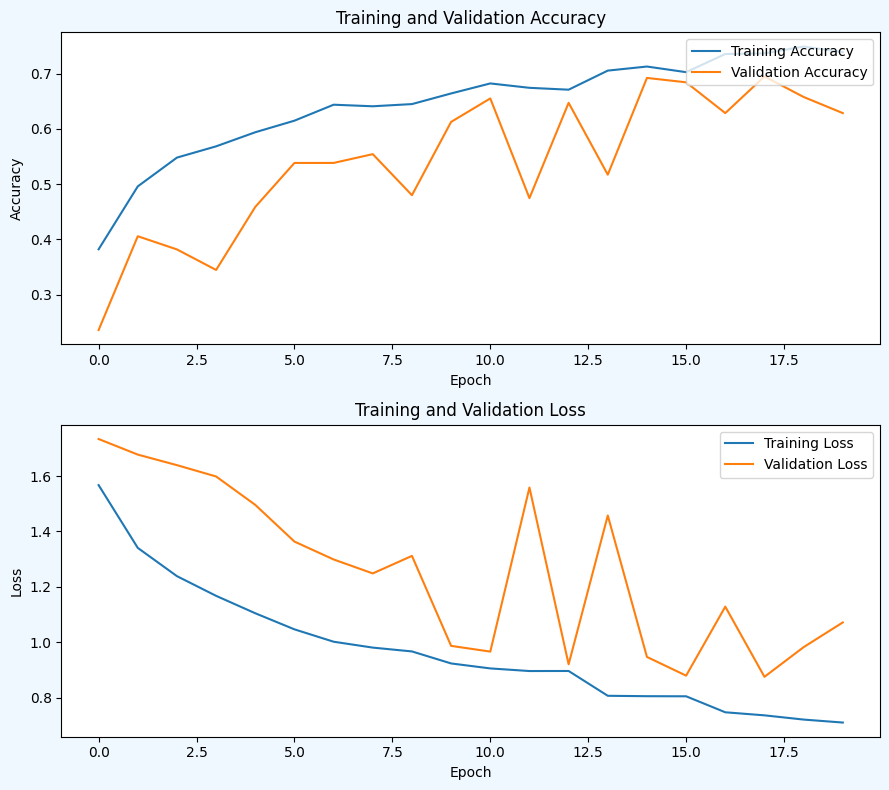

In [94]:
model_norm_batch = Sequential([
       layers.Input(shape = (256, 256, 3)),
    
        layers.Conv2D(32, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.BatchNormalization(),
    
        layers.Conv2D(64, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        #layers.Dropout(rate=0.3),

        layers.Conv2D(128, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        
        layers.Flatten(), # layer converts all feature map
    s into a one-dimensional vector
        layers.Dense(128, activation='relu'),
        layers.Dropout(rate=0.4),
        layers.Dense(len(classes), activation='softmax') # Output Classification layer
        ])

model_norm_batch.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
                          metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])
model_norm_batch.summary()
history = model_norm_batch.fit(train_ds, epochs = 20, validation_data = val_ds, callbacks = [early_stopping])
metrics_model= metrics(model_norm_batch, val_ds)
performance_plot(model_norm_batch, history)

#### Let`s evaluate on more epochs

Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_129 (Conv2D)           │ (None, 128, 128, 32)  │          416 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_129             │ (None, 64, 64, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_25        │ (None, 64, 64, 32)    │          128 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_130 (Conv2D)           │ (None, 32, 32, 64)    │        8,256 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_130             │ (None, 16, 16, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_131 (Conv2D)           │ (None, 8, 8, 128)     │       32,896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_131             │ (None, 4, 4, 128)     │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_52 (Flatten)          │ (None, 2048)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_104 (Dense)             │ (None, 128)           │      262,272 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_29 (Dropout)          │ (None, 128)           │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_105 (Dense)             │ (None, 6)             │          774 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 304,742 (1.16 MB)

 Trainable params: 304,678 (1.16 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step - accuracy: 0.3376 - auc_51: 0.6923 - loss: 1.6235 - precision_52: 0.5948 - recall_52: 0.0847 - val_accuracy: 0.3103 - val_auc_51: 0.6619 - val_loss: 1.7077 - val_precision_52: 0.0000e+00 - val_recall_52: 0.0000e+00
Epoch 2/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - accuracy: 0.5177 - auc_51: 0.8277 - loss: 1.2887 - precision_52: 0.7048 - recall_52: 0.2896 - val_accuracy: 0.2414 - val_auc_51: 0.6625 - val_loss: 1.7091 - val_precision_52: 0.0000e+00 - val_recall_52: 0.0000e+00
Epoch 3/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - accuracy: 0.5667 - auc_51: 0.8476 - loss: 1.2248 - precision_52: 0.7148 - recall_52: 0.3235 - val_accuracy: 0.2891 - val_auc_51: 0.6980 - val_loss: 1.6405 - val_precision_52: 0.0000e+00 - val_recall_52: 0.0000e+00
Epoch 4/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - accuracy: 0.6062 - auc_51: 0.8755 - loss: 1.1059 - precision_52: 0.7616 - recall_52: 0.4209 - val_accuracy: 0.4138 - val_auc_51: 0.7555 - 

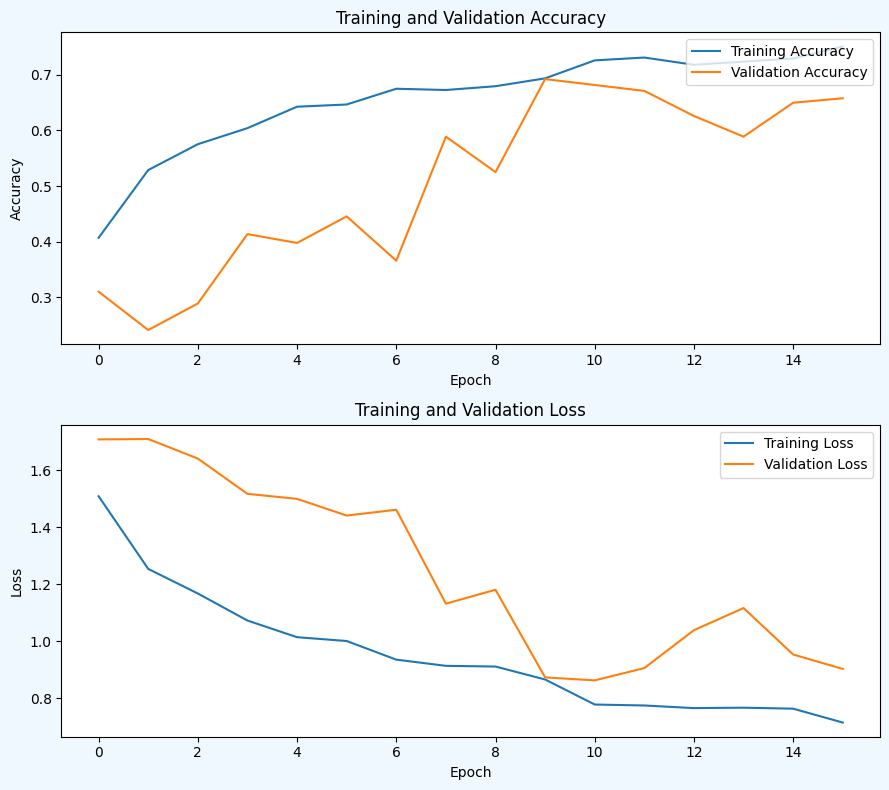

In [100]:
model_norm_batch1 = Sequential([
       layers.Input(shape = (256, 256, 3)),
    
        layers.Conv2D(32, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.BatchNormalization(),
    
        layers.Conv2D(64, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        #layers.Dropout(rate=0.3),

        layers.Conv2D(128, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        
        layers.Flatten(), # layer converts all feature maps into a one-dimensional vector
        layers.Dense(128, activation='relu'),
        layers.Dropout(rate=0.25),
        layers.Dense(len(classes), activation='softmax') # Output Classification layer
        ])

model_norm_batch1.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
                          metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])
model_norm_batch1.summary()
history = model_norm_batch1.fit(train_ds, epochs = 40, validation_data = val_ds, callbacks = [early_stopping])
metrics_model= metrics(model_norm_batch1, val_ds)
performance_plot(model_norm_batch1, history)

Найкращі показники якості моделі: 
* Validation Loss: 0.70
* Validation Accuracy: 73.21%
* Validation Precision: 81.67%
* Validation Recall: 67.37%
* AUC: 0.95%


## Evaluation

In [215]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_186 (Conv2D)             │ (None, 128, 128, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_186               │ (None, 64, 64, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_187 (Conv2D)             │ (None, 32, 32, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_187               │ (None, 16, 16, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_188 (Conv2D)             │ (None, 8, 8, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_188               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_71 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,742 (1.16 MB)

 Trainable params: 304,678 (1.16 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 204ms/step - accuracy: 0.3431 - auc_70: 0.6940 - loss: 1.6413 - precision_71: 0.5321 - recall_71: 0.0905 - val_accuracy: 0.2361 - val_auc_70: 0.6416 - val_loss: 1.7441 - val_precision_71: 0.0000e+00 - val_recall_71: 0.0000e+00
Epoch 2/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.4873 - auc_70: 0.8121 - loss: 1.3297 - precision_71: 0.7172 - recall_71: 0.2719 - val_accuracy: 0.3660 - val_auc_70: 0.7389 - val_loss: 1.6965 - val_precision_71: 0.0000e+00 - val_recall_71: 0.0000e+00
Epoch 3/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - accuracy: 0.5388 - auc_70: 0.8515 - loss: 1.2046 - precision_71: 0.7278 - recall_71: 0.3422 - val_accuracy: 0.4748 - val_auc_70: 0.7740 - val_loss: 1.6290 - val_precision_71: 0.0000e+00 - val_recall_71: 0.0000e+00
Epoch 4/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.5783 - auc_70: 0.8687 - loss: 1.1384 - precision_71: 0.7127 - recall_71: 0.3990 - val_accuracy: 0.4881 - val_auc_70: 0.7958 - 

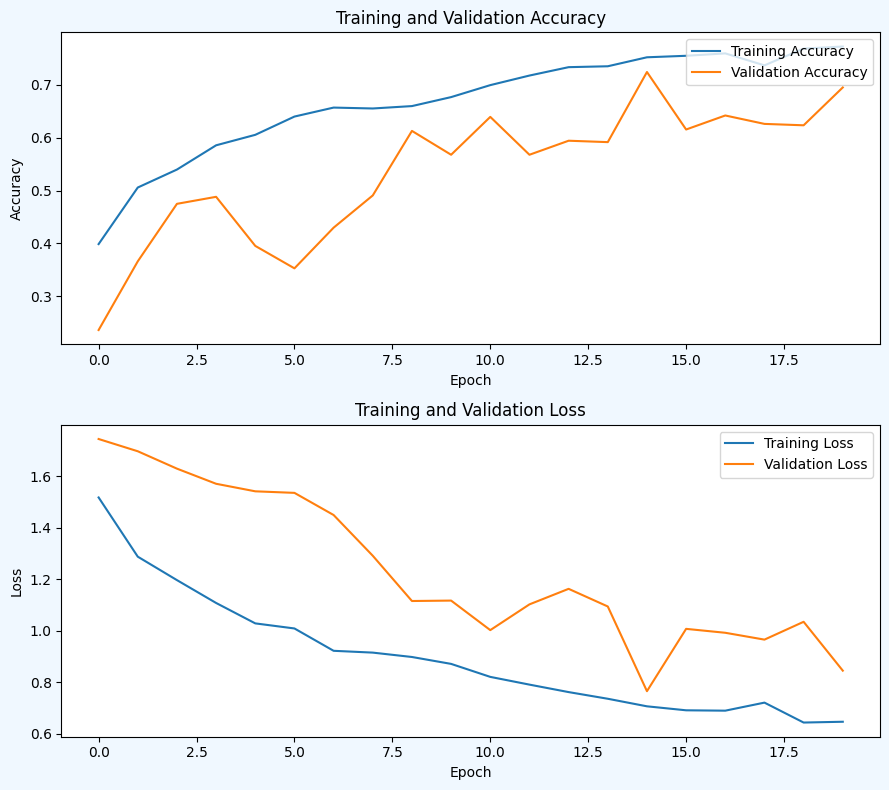

In [229]:
final_cnn = Sequential([
       layers.Input(shape = (256, 256, 3)),
    
        layers.Conv2D(32, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.BatchNormalization(),
    
        layers.Conv2D(64, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.Dropout(rate=0.3),

        layers.Conv2D(128, kernel_size=(2, 2), strides=(2, 2), padding = 'same', activation="relu"),
        #layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2,2)),
        
        layers.Flatten(), # layer converts all feature maps into a one-dimensional vector
        layers.Dense(128, activation='relu'),
        #layers.Dropout(rate=0.2),
        layers.Dense(len(classes), activation='softmax') # Output Classification layer
        ])

final_cnn.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
                          metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])
final_cnn.summary()

# Set up TensorBoard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = final_cnn.fit(train_ds, epochs = 40, validation_data = val_ds, callbacks = [early_stopping, tensorboard_callback])

metrics_final = metrics(final_cnn, val_ds)
performance_plot(final_cnn, history)

In [221]:
tensorboard --logdir=logs

ERROR: Failed to launch TensorBoard (exited with 3221225794).

In [231]:
df_metrics_final_val = pd.DataFrame([metrics_final], columns = ['Val Loss','Val Acc', 'Val Precision', 'Val Recall', 'Val AUC'])
df_metrics_final_val

Val Loss   Val Acc  Val Precision  Val Recall   Val AUC
0  0.765196  0.724138       0.834507    0.628647  0.940892

In [232]:
print(f'Evaluation on the Test Data: ')
df_metrics_final_test = pd.DataFrame([metrics(final_cnn, test_ds)], columns = ['Test Loss','Test Acc', 'Test Precision', 'Test Recall', 'Test AUC'])
df_metrics_final_test

Evaluation on the Test Data: 

Validation Loss: 0.87
Validation Accuracy: 70.31%
Validation Precision: 88.37%
Validation Recall: 49.48%
AUC: 93.11%


Test Loss  Test Acc  Test Precision  Test Recall  Test AUC
0   0.867315  0.703125        0.883721     0.494792  0.931076

# Prediction

Found 384 images belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


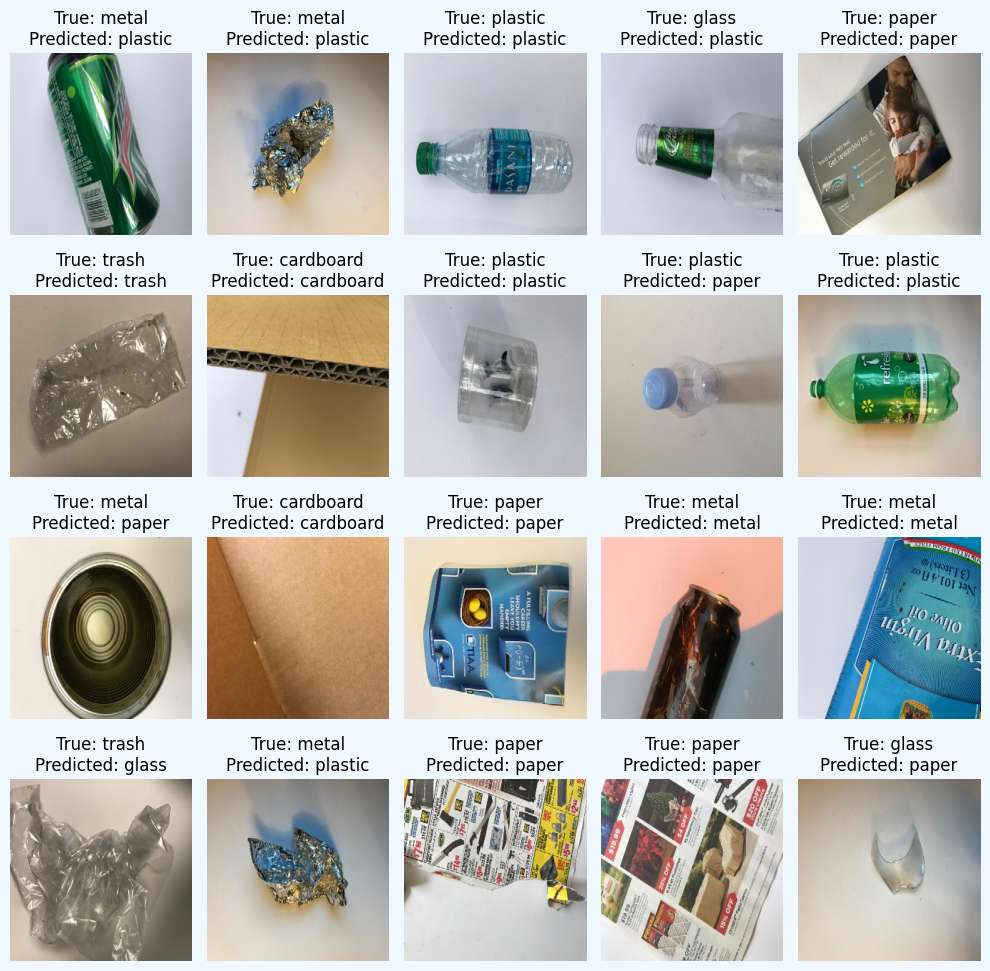

In [234]:
test_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256), 
    batch_size=1,
    class_mode='categorical', 
    shuffle=True
)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Predict on each image and plot results
num_images = 20
plt.figure(figsize=(10, 10), facecolor='aliceblue')
for i in range(num_images):
    image, label = next(test_generator)
    prediction = final_cnn.predict(image)
    predicted_class = class_labels[np.argmax(prediction)]
    true_class = class_labels[np.argmax(label)]
    
    plt.subplot(4, 5, i + 1)
    plt.imshow(image[0])
    plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Comparison with MLPClassifier

In [191]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [192]:
def load_images_dataset(dir, classes, image_size = (128, 128)):
    X = []
    y = []
    for cls in classes:
        folder = os.path.join(dir, cls)
        for file in os.listdir(folder):
            img_path = os.path.join(folder, file)
            with Image.open(img_path) as img:
                img = img.resize(image_size)
                img_array = np.array(img, dtype=np.float32) / 255.0
                X.append(img_array.flatten())
                y.append(cls)
                
    X = np.array(X, dtype=np.float32)
    y = LabelEncoder().fit_transform(y)  # перетворюємо класи в числа
    return X, y

In [195]:
def evaluation(model, X, y_true):
    y_pred = model.predict(X)

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average = 'weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    auc = roc_auc_score(y_true, model.predict_proba(X), multi_class = 'ovr', average='weighted')
    
    return np.array([acc, precision, recall, f1, auc])

In [196]:
X_train, y_train = load_images_dataset(train_dir, classes)
X_val, y_val = load_images_dataset(val_dir, classes)
X_test, y_test = load_images_dataset(test_dir, classes)

In [197]:
sc=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_val_scaled = scaler.fit_transform(X_val)

In [198]:
clf = MLPClassifier(activation='relu',
                    solver='adam', 
                    max_iter=40, 
                    random_state=42, 
                    verbose=False)
clf.fit(X_train_scaled, y_train)

C:\Python\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=40, random_state=42)

In [199]:
columns = ['Accuracy','Precision', 'Recall', 'F1-score', 'AUC']

print(f'Model evaluation on validation dataset\n ')
pd.DataFrame([evaluation(clf, X_val_scaled, y_val)], columns = columns)

Model evaluation on validation dataset
 


Accuracy  Precision    Recall  F1-score       AUC
0  0.572944   0.576361  0.572944  0.571596  0.821621

In [235]:
df_metrics_final_val

Val Loss   Val Acc  Val Precision  Val Recall   Val AUC
0  0.765196  0.724138       0.834507    0.628647  0.940892

In [200]:
columns = ['Accuracy','Precision', 'Recall', 'F1-score', 'AUC']

print(f'Model evaluation on test dataset\n ')
pd.DataFrame([evaluation(clf, X_test_scaled, y_test)], columns = columns)

Model evaluation on test dataset
 


Accuracy  Precision   Recall  F1-score       AUC
0   0.53125   0.538119  0.53125  0.533226  0.801981

In [236]:
df_metrics_final_test

Test Loss  Test Acc  Test Precision  Test Recall  Test AUC
0   0.867315  0.703125        0.883721     0.494792  0.931076

**Висновок:**
У ході виконання лабораторної роботи була побудована модель згорткових нейронних мереж за допомогою біблiотеки TensorFlow та API Keras. Модель створена для класифікації зображень сміття за категоріями, з датасету **№20. Garbage Classification, kaggle.com**. 
Для підвищення якості моделей і запобігання перенавчанню застосовувались техніки data augmentation, ранньої зупинки навчання, дропауту та регуляризації.

Після дослідження параметрів padding i strides та kernel для базової моделі з одним згортковим шаром були обрані У ході виконання лабораторної роботи була побудована модель згорткових нейронних мереж за допомогою біблiотеки TensorFlow та API Keras. Модель створена для класифікації зображень сміття за категоріями, з датасету №20. Garbage Classification, kaggle.com. kernel_size=(2, 2), strides=(2, 2), padding = 'same'**. Ці параметри мали високу точність та були обрані виходячи з найменшого значення функції втрат та високих показників метрик Precision, Recall та AUC.
* Validation Loss: 1.10
* Validation Accuracy: 57.82%
* Validation Precision: 79.31%
* Validation Recall: 36.60%

Надалі була створена модель з трьома згортковими шарами, доповнена макспулінгом, що мала наступні показники: 
* Validation Loss: 0.91
* Validation Accuracy: 67.90%


З додаванням більшої кількості нормалізації на згорткових шарах, спостерігалось погіршення поведінки моделі, зі зниженням точності та збільшенням показників втрат.

Модель мала вищу точність для шарів дропауту при більшому значенні параметра rate.

В рузультаті, кінцева модель має три згорткових шари, доповнені одним шаром нормалізації, дропауту (rate=0.3) та шарами макспулінгу. Пiсля згорткових слiдують повнозв’язнi шари: з активацiєю ReLU, та вихiдний з активацiєю SoftMax. Рузультати моделі наступні:
* Рання зупинка на 20/40 epochs
* Validation Loss: 0.77  |  Test  Loss: 0.87
* Validation Accuracy: 72.41%  |  Test  Accuracy: 70.31%
* Validation Precision: 83.45%  |   Test  Precision: 88.37%
* Validation Recall: 62.86%   |   Test  Recall: 49.48%
* Validation AUC: 94%   |   Test  AUC: 93

Такі низька показники точності та високі функції втрат можуть свідчити про необхідність кращого балансування даних, або введення додаткових фільтрів, які не будуть ускліднювати архітектури моделі.

Для порівняння була також реалізована модель багатошарового персептрона (MLP) з використанням MLPClassifier з бібліотеки sklearn. Модель показала помітно нижчі результати:
* Validation Accuracy: 57%  |  Test  Accuracy: 53%
* Validation Precision: 58%  |   Test  Precision: 53%
* Validation Recall: 57%   |   Test  Recall: 53%
* Validation AUC: 82%   |   Test  AUC: 80%
* Validation F1-score: 57%   |   Test  F1-score: 53%


